# The mass-dependent UVJ diagram at cosmic noon: A challenge for galaxy evolution models and dust radiative transfer

Analysis for [Gebek et al. 2025](https://www.aanda.org/articles/aa/abs/2025/03/aa52768-24/aa52768-24.html) where we study the stellar mass-dependent rest-frame UVJ diagram at $z=2$ in 3D-HST observational data and with postprocessed cosmological simulations.

## Preparation

Import packages and plotting settings.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib
import h5py
from scipy.interpolate import interp1d, RegularGridInterpolator
import scipy.stats as st
import os
from scipy.ndimage import gaussian_filter1d as gauss

plotFactor = 0.6
matplotlib.rcParams['axes.linewidth'] = 1.5 * plotFactor
matplotlib.rcParams['xtick.major.size'] = 6 * plotFactor
matplotlib.rcParams['xtick.minor.size'] = 4 * plotFactor
matplotlib.rcParams['xtick.major.width'] = 1.5 * plotFactor
matplotlib.rcParams['xtick.minor.width'] = 1. * plotFactor
matplotlib.rcParams['ytick.major.size'] = 6 * plotFactor
matplotlib.rcParams['ytick.minor.size'] = 4 * plotFactor
matplotlib.rcParams['ytick.major.width'] = 1.5 * plotFactor
matplotlib.rcParams['ytick.minor.width'] = 1. * plotFactor
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams.update({'font.size': 22 * plotFactor})

This study makes use of the following observational datasets:
- JWST_NIRCam.hdf5: Main observational data, based on a morphological catalogue created by Aurélien Genin. Downloaded from the DJA (https://dawn-cph.github.io/dja/blog/2024/08/16/morphological-data/).
- 3DHST_Gebek24.hdf5: Data based on the CANDELS/3D-HST survey (https://archive.stsci.edu/prepds/3d-hst/) using the photometric catalogues from Skelton et al. 2014. EAZY run by us.
- 3DHST_Skelton14.hdf5: Data based on the CANDELS/3D-HST survey (https://archive.stsci.edu/prepds/3d-hst/) using the photometric catalogues from Skelton et al. 2014.

And we also use the following simulation datasets:
- TNG100.hdf5: Data from the TNG100 simulation (https://www.tng-project.org/), including many different dust-attenuated fluxes generated by us with SKIRT.
- TNG300.hdf5: Data from the TNG300 simulation (https://www.tng-project.org/), including dust-attenuated fluxes generated by us with SKIRT. 
- EAGLE: Data from the public database of the EAGLE simulation (https://icc.dur.ac.uk/Eagle/database.php).

The following table gives an overview of the number of galaxies in each dataset. All samples are selected with a stellar mass threshold of $M_\star>10^{9.5}\,\mathrm{M}_\odot$ using the total gravitationally bound stellar mass for the simulations. Additionally, the observational samples are selected to be in the redshift range $1.8<z<2.2$.

|Filename|$N_\mathrm{gal}$|Flags|
|-------|-------|------|
|JWST_NIRCam.hdf5|3609|flag=2|
|3DHST_Gebek24.hdf5|4941|use_phot=1 and star_flag=0|
|3DHST_Skelton14.hdf5|3265|use_phot=1 and star_flag=0|
|TNG100.hdf5|6442|SubhaloFlag=1|
|TNG300.hdf5|94980|SubhaloFlag=1|
|EAGLE.hdf5|3568|flag=0|

The following table describes the available fields for each dataset.

|Field name|Description|Unit|JWST_NIRCam|3DHST_Gebek24|3DHST_Skelton14|TNG100|TNG300|EAGLE|
|-------|-------|------|-------|-------|------|-------|-------|------|
|ID|Galaxy ID|-|yes|yes|yes|yes|yes|yes|
|field|Observational field|-|yes|yes|yes|no|no|no|
|z|Redshift|-|yes|yes|yes|no|no|no|
|mstar|Stellar mass|$\mathrm{M}_\odot$|yes|yes|yes|yes|yes|yes|
|mmetals|ISM metal mass in dust-containing gas cells (using Torrey et al. 2012 criterion)|$\mathrm{M}_\odot$|no|no|no|yes|no|no|
|sfr|Star-formation rate|$\mathrm{M}_\odot\mathrm{yr}^{-1}$|yes|yes|no|yes|yes|yes|
|Mag_UVJ|Absolute rest-frame AB magnitude in UVJ bands|mag|yes|yes|yes|yes|no|no|yes*|
|Mag_UVJ_Nelson18|Absolute rest-frame AB magnitude in UVJ bands from Nelson et al. 2018|mag|no|no|no|yes|yes|no|
|Mag_UVJ_SKIRT|Absolute rest-frame AB magnitude in UVJ bands calculated using SKIRT in this work|mag|no|no|no|yes**|yes**|no|
|flux_radius|Circular half-light radius in F160W band|pc|no|no|yes|no|no|no|
|kron_radius|Kron radius in F160W band|pc|no|no|yes|no|no|no|
|StellarHalfMassRad|3D stellar half-mass radius|pc|no|no|no|yes|no|no|

*Note that EAGLE galaxies with less than 250 dust-containing gas particles do not have calculated UVJ magnitudes (56 out of the full sample of 3568 galaxies). The missing values are set to nan.

**There are multiple fields in TNG100 and TNG300 that start with "Mag_UVJ_SKIRT", followed by a name which specifies the SKIRT model that was used. Note that for some cases ("Mag_UVJ_SKIRT_fDust05_BPASS_TODDLERS_THEMIS" for TNG300, "Mag_UVJ_SKIRT_fDust05_BPASS_TODDLERS_DraineLi" / "Mag_UVJ_SKIRT_fDust05_BPASS_TODDLERS_Zubko" /"Mag_UVJ_SKIRT_fDust05_BPASS_TODDLERS_THEMIS_dustEverywhere" for TNG100), not all galaxies have SKIRT-calculated magnitudes available. The missing values are set to nan. Also, note that all of these magnitudes are calculated in circular apertures of 30 kpc, except for "Mag_UVJ_SKIRT_fDust05_BPASS_TODDLERS_THEMIS_5R" which uses an aperture of 5 stellar half-mass radii.

Additional datasets:

- DIRTY.hdf5: V-J/U-V colors (in AB magnitudes) for a grid of geometrical models (https://stsci.app.box.com/v/dirtygrid, see Law et al. 2018). The specifications of the grid are given in the hdf5 file attributes.
- BPASSfluxes.txt: Fluxes in the UVJ bands (in Jy) for the BPASS SED library (the version which is implemented in SKIRT) for an SSP of one solar mass at a distance of 10 Mpc, parametrized on age and metallicity.
- TNG100ToyModel.hdf5: Results for the two-component attenuation toy model for massive, star-forming TNG100 galaxies. Given are the subhalo IDs, dust-attenuated and dust-free UVJ magnitudes for all these subhalos for various parameters in the toy model, and dust-attenuated UVJ magnitudes for a single example galaxy on a much finer parameter grid of the toy model. More information on the parameters can be found in the hdf5 file header.
- .dat files in SVO_bands: Broadband filter files downloaded from http://svo2.cab.inta-csic.es/theory/fps/. The files contain the wavelengths (in Angstrom) and the transmissions of the three UVJ Johnson filters.
- TNG100_ID63990_*.dat: These files are the output of SKIRT runs for a single TNG100 galaxy at $z=2$ (ID: 63990). These runs were performed with more photon packets and the resulting SED is stored at relatively high spectral resolution for visualization (as opposed to the fiducial SKIRT results which only include broadband fluxes). Specifically, the TNG100_ID63990_SED.dat file corresponds to our fiducial SKIRT setup (also storing the luminosity probe which contains the fractional contributions of BPASS and TODDLERS to the total SED), while the TNG100_ID63990_SED_onlyBPASS.dat file was run using BPASS for all stellar populations.

Set up a class which contains functionality that we need for all datasets.

In [2]:
class Dataset:
    def __init__(self, filename, verbose = False):

        self.filename = filename

        file_relativePath = 'data/' + self.filename + '.hdf5'

        if not os.path.isfile(file_relativePath):
            raise Exception('File:', file_relativePath, 'does not exist.')

        self.data = {} # This is a dictionary that holds the relevant data

        # Read in all information that is in the hdf5 file into a dictionary

        with h5py.File(file_relativePath) as f:

            if verbose:
                print('Available fields for file ' + self.filename + ':', f.keys())

            for idx, key in enumerate(f.keys()):
                self.data[key] = f[key][:]

                if idx == 0 and verbose:
                    print('Number of galaxies in this dataset:', len(f[key][:]))

    def getLogmstar(self):
        return np.log10(self.data['mstar']) # In log10(Mstar/Msun)

    def getSFR(self):
        if 'sfr' not in self.data.keys():
            raise Exception('sfr', 'is not stored for dataset', self.filename)
        return self.data['sfr'] # In Msun/yr

    def getsSFR(self):
        SFR = self.getSFR()
        return SFR / self.data['mstar'] # In 1/yr

For TNG100, set up a different class which also has functionality to compare different SKIRT models.

In [3]:
class TNG100dataset(Dataset):
    def getUVJdifferences(self, MagnitudeKey1, MagnitudeKey2, takeAbsValue = True):
        # Compute the percentiles and medians of absolute values of U-V and V-J color differences between two SKIRT models

        logmstarBins = np.array([9.5, 10., 10.5, 11., np.inf])

        Mag_UVJ_1 = self.data['Mag_UVJ_SKIRT_' + MagnitudeKey1]
        Mag_UVJ_2 = self.data['Mag_UVJ_SKIRT_' + MagnitudeKey2]

        if np.any(np.isnan(Mag_UVJ_1)) or np.any(np.isnan(Mag_UVJ_2)):
            print('Caution: nan values detected in the magnitudes.')

        for idx in range(len(logmstarBins) - 1):
            SELmstar = (self.getLogmstar() >= logmstarBins[idx]) * (self.getLogmstar() < logmstarBins[idx + 1])

            if takeAbsValue:
                VJ_diff = np.abs((Mag_UVJ_1[SELmstar, 1] - Mag_UVJ_1[SELmstar, 2]) - (Mag_UVJ_2[SELmstar, 1] - Mag_UVJ_2[SELmstar, 2]))
                UV_diff = np.abs((Mag_UVJ_1[SELmstar, 0] - Mag_UVJ_1[SELmstar, 1]) - (Mag_UVJ_2[SELmstar, 0] - Mag_UVJ_2[SELmstar, 1]))

            else:
                VJ_diff = (Mag_UVJ_1[SELmstar, 1] - Mag_UVJ_1[SELmstar, 2]) - (Mag_UVJ_2[SELmstar, 1] - Mag_UVJ_2[SELmstar, 2])
                UV_diff = (Mag_UVJ_1[SELmstar, 0] - Mag_UVJ_1[SELmstar, 1]) - (Mag_UVJ_2[SELmstar, 0] - Mag_UVJ_2[SELmstar, 1])

            VJ_lowerPercentile = np.round(np.nanpercentile(VJ_diff, 15.87), 3)
            VJ_median = np.round(np.nanmedian(VJ_diff), 3)
            VJ_upperPercentile = np.round(np.nanpercentile(VJ_diff, 84.14), 3)

            UV_lowerPercentile = np.round(np.nanpercentile(UV_diff, 15.87), 3)
            UV_median = np.round(np.nanmedian(UV_diff), 3)
            UV_upperPercentile = np.round(np.nanpercentile(UV_diff, 84.14), 3)

            print('Absolute V-J color differences (15.87, 50, 84.14 percentiles) for stellar mass bin', idx, ':', VJ_lowerPercentile, VJ_median, VJ_upperPercentile)
            print('Absolute U-V color differences (15.87, 50, 84.14 percentiles) for stellar mass bin', idx, ':', UV_lowerPercentile, UV_median, UV_upperPercentile, '\n')
            
        return None

Generate all the dataset objects:

In [4]:
JWST_NIRCam = Dataset('JWST_NIRCam', verbose = True) # Main observational dataset
HST_Gebek24 = Dataset('3DHST_Gebek24')
HST_Skelton14 = Dataset('3DHST_Skelton14')
EAGLE = Dataset('EAGLE')
TNG100 = TNG100dataset('TNG100', verbose = True) # Main simulation dataset
TNG300 = Dataset('TNG300')

Available fields for file JWST_NIRCam: <KeysViewHDF5 ['A_V', 'ID', 'Mag_UVJ', 'field', 'mstar', 'sfr', 'z']>
Number of galaxies in this dataset: 3609
Available fields for file TNG100: <KeysViewHDF5 ['ID', 'Mag_UVJ_Nelson18', 'Mag_UVJ_SKIRT_fDust01_BPASS_TODDLERS_THEMIS', 'Mag_UVJ_SKIRT_fDust05_BC03_TODDLERS_THEMIS', 'Mag_UVJ_SKIRT_fDust05_BPASS_TODDLERS_DraineLi', 'Mag_UVJ_SKIRT_fDust05_BPASS_TODDLERS_THEMIS', 'Mag_UVJ_SKIRT_fDust05_BPASS_TODDLERS_THEMIS_5R', 'Mag_UVJ_SKIRT_fDust05_BPASS_TODDLERS_THEMIS_dustEverywhere', 'Mag_UVJ_SKIRT_fDust05_BPASS_TODDLERS_Zubko', 'Mag_UVJ_SKIRT_fDust05_FSPS_TODDLERS_THEMIS', 'Mag_UVJ_SKIRT_fDust0_BC03', 'Mag_UVJ_SKIRT_fDust0_BPASS', 'Mag_UVJ_SKIRT_fDust0_BPASS_MAPPINGS', 'Mag_UVJ_SKIRT_fDust0_BPASS_TODDLERS', 'Mag_UVJ_SKIRT_fDust0_FSPS', 'Mag_UVJ_SKIRT_fDust1_BPASS_TODDLERS_THEMIS', 'Mag_UVJ_SKIRT_fStarDust05fDust_BPASS_TODDLERS_THEMIS', 'StellarHalfmassRad', 'mmetals', 'mstar', 'sfr']>
Number of galaxies in this dataset: 6442


Define a class which holds multiple datasets to plot UVJ diagrams:

In [5]:
class Datasets:
    def __init__(self, datasetList):

        self.datasetList = []

        for singleDataset in datasetList:
            self.datasetList.append(singleDataset)

    def getUVJdifferences(self, magnitudeKeys, referenceDatasetIdx = 0):
        # By default, use the first dataset in the datasetList as reference

        logmstarBins = np.array([9.5, 10., 10.5, 11., np.inf])

        Mag_UVJ_reference = self.datasetList[referenceDatasetIdx].data[magnitudeKeys[referenceDatasetIdx]]
        logmstar_reference = self.datasetList[referenceDatasetIdx].getLogmstar()

        for counter in range(len(self.datasetList)):
            if counter == referenceDatasetIdx:
                continue

            Mag_UVJ_comparison = self.datasetList[counter].data[magnitudeKeys[counter]]
            logmstar_comparison = self.datasetList[counter].getLogmstar()

            for idxMstar in range(len(logmstarBins) - 1):
                SELmstar_reference = (logmstar_reference >= logmstarBins[idxMstar]) * (logmstar_reference < logmstarBins[idxMstar + 1])
                SELmstar_comparison = (logmstar_comparison >= logmstarBins[idxMstar]) * (logmstar_comparison < logmstarBins[idxMstar + 1])

                VJ_reference = Mag_UVJ_reference[SELmstar_reference, 1] - Mag_UVJ_reference[SELmstar_reference, 2]
                VJ_comparison = Mag_UVJ_comparison[SELmstar_comparison, 1] - Mag_UVJ_comparison[SELmstar_comparison, 2]
                UV_reference = Mag_UVJ_reference[SELmstar_reference, 0] - Mag_UVJ_reference[SELmstar_reference, 1]
                UV_comparison = Mag_UVJ_comparison[SELmstar_comparison, 0] - Mag_UVJ_comparison[SELmstar_comparison, 1]

                VJ_lowerPercentile = np.round(np.nanpercentile(VJ_reference, 15.87) - np.nanpercentile(VJ_comparison, 15.87), 3)
                VJ_median = np.round(np.nanmedian(VJ_reference) - np.nanmedian(VJ_comparison), 3)
                VJ_upperPercentile = np.round(np.nanpercentile(VJ_reference, 84.14) - np.nanpercentile(VJ_comparison, 84.14), 3)

                UV_lowerPercentile = np.round(np.nanpercentile(UV_reference, 15.87) - np.nanpercentile(UV_comparison, 15.87), 3)
                UV_median = np.round(np.nanmedian(UV_reference) - np.nanmedian(UV_comparison), 3)
                UV_upperPercentile = np.round(np.nanpercentile(UV_reference, 84.14) - np.nanpercentile(UV_comparison, 84.14), 3)

                print('V-J color differences (15.87, 50, 84.14 percentiles) for stellar mass bin', idxMstar, 'comparing dataset', counter, 'to the reference:', VJ_lowerPercentile, VJ_median, VJ_upperPercentile)
                print('U-V color differences (15.87, 50, 84.14 percentiles) for stellar mass bin', idxMstar, 'comparing dataset', counter, 'to the reference:', UV_lowerPercentile, UV_median, UV_upperPercentile, '\n')

        return None

    def computeKDE(self, xData, yData):

        percentileLevels = [0.05, 0.3, 0.75, 0.95] # Levels at which to draw the percentile contours
        xmin = -0.3 # Minimum V-J
        xmax = 3.4 # Maximum V-J
        ymin = 0. # Minimum U-V
        ymax = 2.9 # Maximum U-V
        kdeResolution = 100j # Resolution of the KDE

        xx, yy = np.mgrid[xmin:xmax:kdeResolution, ymin:ymax:kdeResolution]
        positions = np.vstack([xx.ravel(), yy.ravel()])

        values = np.vstack([xData, yData])
        kernel = st.gaussian_kde(values)
        KDE = np.reshape(kernel(positions).T, xx.shape) # 2d array with kde estimate


        percentiles = np.cumsum(np.sort(KDE, axis = None)) / np.sum(KDE) # 1d array of the sorted cumulative sum of the kde estimate (normalized to 1)
        argPercentiles = []

        for number in percentileLevels: # The percentile levels
            argPercentiles.append(np.argmax(percentiles[percentiles <= number]))

        argPercentiles = np.array(argPercentiles)

        levels = np.sort(KDE, axis = None)[argPercentiles] # The 0.3 level now effectively corresponds to an area enclosing the densest 70% of the galaxy sample

        return xx, yy, KDE, levels

    def plotUVJdiagram(self, datasetIndices, magnitudeKeys, colormaps, labels, Nrows = 1, addCategoryText = False, showAvArrow = False, colorCodingIndices = None):

        logmstarBins = np.array([9.5, 10., 10.5, 11., np.inf])
        titleList = [r'$9.5<\log_{10}(M_\star/\mathrm{M}_\odot)<10$', r'$10<\log_{10}(M_\star/\mathrm{M}_\odot)<10.5$',
            r'$10.5<\log_{10}(M_\star/\mathrm{M}_\odot)<11$', r'$11<\log_{10}(M_\star/\mathrm{M}_\odot)$']

        cmapValues = [0.3, 0.5, 0.7, 0.9] # Colors to use for the percentile levels

        if colorCodingIndices is None:
            axes = plt.subplots(figsize = (12., 1. + 3. * Nrows), nrows = Nrows, ncols = 4)[1]
        else:
            axes = plt.subplots(figsize = (13., 1. + 3. * Nrows), nrows = Nrows, ncols = 4)[1]

        for idxRow in range(Nrows):

            if Nrows > 1:
                datasetIndices_row = datasetIndices[idxRow]
                magnitudeKeys_row = magnitudeKeys[idxRow]
                colormaps_row = colormaps[idxRow]
                if colorCodingIndices is not None:
                    colorCodingIndex_row = colorCodingIndices[idxRow]
            else:
                datasetIndices_row = datasetIndices
                magnitudeKeys_row = magnitudeKeys
                colormaps_row = colormaps
                if colorCodingIndices is not None:
                    colorCodingIndex_row = colorCodingIndices

            for counter, idxDataset in enumerate(datasetIndices_row):

                logmstar = self.datasetList[idxDataset].getLogmstar()

                for idxPanel in range(4):

                    SELmstar = (logmstar >= logmstarBins[idxPanel]) * (logmstar < logmstarBins[idxPanel + 1])

                    Mag_UVJ = self.datasetList[idxDataset].data[magnitudeKeys_row[counter]][SELmstar]

                    SEL_nan = ((np.isnan(Mag_UVJ[:, 0])) + (np.isnan(Mag_UVJ[:, 1])) + (np.isnan(Mag_UVJ[:, 2])))

                    if len(SEL_nan[SEL_nan]) > 0:
                        print('Warning: nan values detected in the UVJ magnitudes in dataset', idxDataset, 'with magnitude key', magnitudeKeys_row[counter])

                    VJ = Mag_UVJ[~SEL_nan, 1] - Mag_UVJ[~SEL_nan, 2]
                    UV = Mag_UVJ[~SEL_nan, 0] - Mag_UVJ[~SEL_nan, 1]

                    xx, yy, KDE, KDElevels = self.computeKDE(VJ, UV)

                    cmap = matplotlib.colormaps[colormaps_row[counter]]

                    if Nrows > 1:
                        axes[idxRow, idxPanel].contour(xx, yy, KDE, levels = KDElevels, colors = [cmap(i) for i in cmapValues], linewidths = 2.5)
                    else:
                        axes[idxPanel].contour(xx, yy, KDE, levels = KDElevels, colors = [cmap(i) for i in cmapValues], linewidths = 2.5)

                    if colorCodingIndices is not None and idxDataset == colorCodingIndex_row:
                        # Add 2D histograms that display sSFR to the plot
                        Nbins = 20
                        VJbins = np.linspace(np.min(xx), np.max(xx), Nbins + 1)
                        UVbins = np.linspace(np.min(yy), np.max(yy), Nbins + 1)

                        sSFR = self.datasetList[idxDataset].getsSFR()[SELmstar][~SEL_nan]
                        weights = np.log10(np.clip(sSFR, a_min = 10**(-11.5), a_max = None))

                        Ngal_inBin = np.histogram2d(VJ, UV, bins = (VJbins, UVbins))[0] # Number of galaxies in a given VJ-UV bin

                        with np.errstate(divide = 'ignore', invalid = 'ignore'):
                            hist = np.histogram2d(VJ, UV, weights = weights, bins = (VJbins, UVbins))[0] / Ngal_inBin

                        if Nrows > 1:
                            im = axes[idxRow, idxPanel].pcolormesh(VJbins, UVbins, hist.T, vmin = -11.5, vmax = -8.5, alpha = 0.6, cmap = 'Spectral')
                        else:
                            im = axes[idxPanel].pcolormesh(VJbins, UVbins, hist.T, vmin = -11.5, vmax = -8.5, alpha = 0.6, cmap = 'Spectral')


        # If color-coding is active, add a colorbar
        if colorCodingIndices is not None:
            if Nrows > 1:
                cax = axes[-1, -1].inset_axes([1.05, 0., 0.08, Nrows])

            else:
                cax = axes[-1].inset_axes([1.05, 0., 0.08, 1.])

            cbar = plt.colorbar(im, cax = cax)
            cbar.minorticks_on()
            cbar.set_label(r'$\log_{10}(\mathrm{sSFR/\mathrm{yr}^{-1}})$')

        # Add the titles and draw the demarcation line

        VJ_Williams = np.linspace(np.min(xx), np.max(xx), 1000)
        UV_Williams = np.where(VJ_Williams <= 1.6, np.clip(0.88 * VJ_Williams + 0.49, a_min = 1.3, a_max = None), np.inf)

        for idxPanel in range(4):
            if Nrows > 1:
                axes[0, idxPanel].set_title(titleList[idxPanel], fontsize = 22 * plotFactor)

                for idxRow in range(Nrows):
                    axes[idxRow, idxPanel].plot(VJ_Williams, UV_Williams, linestyle = '--', color = 'black', linewidth = 2.)
                    axes[idxRow, idxPanel].vlines(1.6, 0.88 * 1.6 + 0.49, np.max(yy), linestyle = '--', color = 'black', linewidth = 2.)

            else:
                axes[idxPanel].set_title(titleList[idxPanel], fontsize = 22 * plotFactor)

                axes[idxPanel].plot(VJ_Williams, UV_Williams, linestyle = '--', color = 'black', linewidth = 2.)
                axes[idxPanel].vlines(1.6, 0.88 * 1.6 + 0.49, np.max(yy), linestyle = '--', color = 'black', linewidth = 2.)
        

        # Add the quiescent and star-forming region labels
        if addCategoryText:
            if Nrows > 1:
                axes[0, 1].text(x = 0.1, y = 0.8, s = 'Quiescent', transform = axes[0, 1].transAxes)
                axes[0, 1].text(x = 0.5, y = 0.1, s = 'Star-forming', transform = axes[0, 1].transAxes)
            else:
                axes[1].text(x = 0.1, y = 0.8, s = 'Quiescent', transform = axes[1].transAxes)
                axes[1].text(x = 0.5, y = 0.1, s = 'Star-forming', transform = axes[1].transAxes)
        
        # Plot an arrow which indicates dust THEMIS dust extinction of A_V = 1 mag
        if showAvArrow:
            prop = dict(arrowstyle = '-|>,head_width=0.4,head_length=0.8', shrinkA = 0, shrinkB = 0, facecolor = 'black', linewidth = 3.)
            A_V = 1.

            if Nrows > 1:
                axes[0, 1].annotate('', xy = (2. + 0.664 * A_V, 0.8 + 0.661 * A_V), xytext = (2., 0.8), arrowprops = prop)
                axes[0, 1].text(x = 2.1, y = 0.6, s = r'$A_\mathrm{V}=1\,\mathrm{mag}$', rotation = 45., transform_rotates_text = True)

            else:
                axes[1].annotate('', xy = (2. + 0.664 * A_V, 0.8 + 0.661 * A_V), xytext = (2., 0.8), arrowprops = prop)
                axes[1].text(x = 2.1, y = 0.6, s = r'$A_\mathrm{V}=1\,\mathrm{mag}$', rotation = 45., transform_rotates_text = True)


        # Finalize the plotting settings and add the legends
        plt.tight_layout()

        if Nrows > 1:
            axes[-1, 0].set_xlabel(r'$V-J\,[\mathrm{mag}]$')
            axes[-1, 1].set_xlabel(r'$V-J\,[\mathrm{mag}]$')
            axes[-1, 2].set_xlabel(r'$V-J\,[\mathrm{mag}]$')
            axes[-1, 3].set_xlabel(r'$V-J\,[\mathrm{mag}]$')
                
            for ax in axes.flatten():

                ax.tick_params(which='both', direction='in', top=True, right=True)
                ax.minorticks_on()

            for idxRow in range(Nrows):
                handles = []
                labelsExtended = []

                for idx_cmapValue, cmapValue in enumerate(cmapValues):
                    for counter in range(len(labels[idxRow])):

                        patch = Patch(facecolor = matplotlib.colormaps[colormaps[idxRow][counter]](cmapValue), edgecolor = 'black')

                        handles.append(patch)

                        if idx_cmapValue < len(cmapValues) - 1:
                            labelsExtended.append('')

                lg = axes[idxRow, 0].legend(loc = 'upper left', handles = handles, labels = labelsExtended + labels[idxRow], ncol = 4, handlelength = 0.7, columnspacing = -0.5, handletextpad = 0.5)
                lg.get_frame().set_linewidth(0.)

                axes[idxRow, 0].set_ylabel(r'$U-V\,[\mathrm{mag}]$')

                axes[idxRow, 1].set_yticklabels([])
                axes[idxRow, 2].set_yticklabels([])
                axes[idxRow, 3].set_yticklabels([])

            plt.subplots_adjust(wspace = 0, hspace = 0)

        else:
            handles = []
            labelsExtended = []

            for idx_cmapValue, cmapValue in enumerate(cmapValues):
                for counter in range(len(labels)):

                    patch = Patch(facecolor = matplotlib.colormaps[colormaps[counter]](cmapValue), edgecolor = 'black')

                    handles.append(patch)

                    if idx_cmapValue < len(cmapValues) - 1:
                        labelsExtended.append('')

            lg = axes[0].legend(loc = 'upper left', handles = handles, labels = labelsExtended + labels, ncol = 4, handlelength = 0.7, columnspacing = -0.5, handletextpad = 0.5)
            lg.get_frame().set_linewidth(0.)

            axes[0].set_ylabel(r'$U-V\,[\mathrm{mag}]$')
            axes[0].set_xlabel(r'$V-J\,[\mathrm{mag}]$')
            axes[1].set_xlabel(r'$V-J\,[\mathrm{mag}]$')
            axes[2].set_xlabel(r'$V-J\,[\mathrm{mag}]$')
            axes[3].set_xlabel(r'$V-J\,[\mathrm{mag}]$')
                    
            for ax in axes:
                ax.tick_params(which='both', direction='in', top=True, right=True)
                ax.minorticks_on()

            axes[1].set_yticklabels([])
            axes[2].set_yticklabels([])
            axes[3].set_yticklabels([])

            plt.subplots_adjust(wspace = 0)

        plt.show()
        plt.close()

        return None

## Figures from the paper

In this section we'll create the figures from the Gebek et al. 2025 paper, i.e. this is our main analysis.

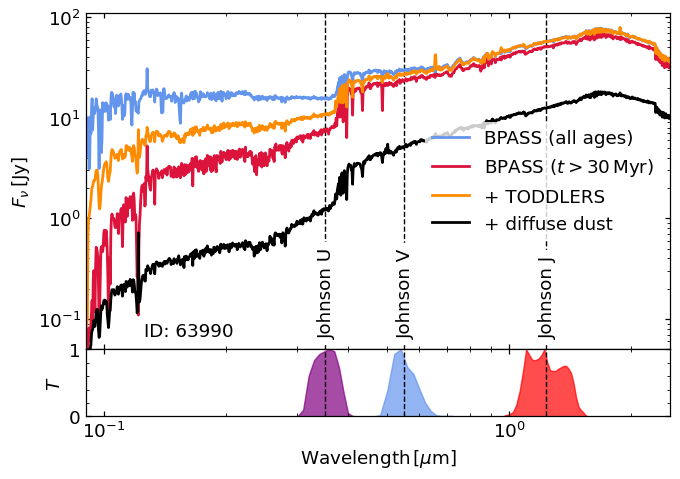

In [6]:
# Figure 1

wavelength_singleSED, F_total, F_transparent = np.loadtxt('data/TNG100_ID63990_SED.dat', unpack = True, usecols = [0, 1, 2])

F_transparent_BPASS = np.loadtxt('data/TNG100_ID63990_SED_onlyBPASS.dat', usecols = 2)

lumFraction_evolvedStars = np.loadtxt('data/TNG100_ID63990_lumProbe.dat', usecols = 3)

fig, axes = plt.subplots(figsize = (7., 5.), nrows = 2, ncols = 1, height_ratios = [1., 0.2])

filterColorList = ['purple', 'cornflowerblue', 'r']
pivotWavelengths = [0.351189, 0.55014, 1.23173] # Pivot wavelengths from the SVO filter profile service

for idx, filter in enumerate(['U', 'V', 'J']):

    wavelength_filter, T_filter = np.loadtxt('data/SVO_bands/Generic_Johnson.' + filter + '.dat', unpack = True) # Wavelength in Angstrom

    axes[1].fill_between(wavelength_filter / 1e4, T_filter / np.max(T_filter), color = filterColorList[idx], alpha = 0.7, linewidth = 1.)

    axes[0].axvline(pivotWavelengths[idx], color = 'black', linestyle = '--', linewidth = 1.)
    axes[1].axvline(pivotWavelengths[idx], color = 'black', linestyle = '--', linewidth = 1.)

    axes[0].text(x = pivotWavelengths[idx] * 0.96, y = 0.07, s = 'Johnson ' + filter, rotation = 'vertical', backgroundcolor = 'white')

axes[0].text(x = 0.1, y = 0.04, s = 'ID: 63990', transform = axes[0].transAxes)

axes[0].loglog(wavelength_singleSED, F_transparent_BPASS, color = 'cornflowerblue', linewidth = 2., label = 'BPASS (all ages)')
axes[0].loglog(wavelength_singleSED, F_transparent * lumFraction_evolvedStars, color = 'crimson', linewidth = 2., label = r'BPASS ($t>30\,\mathrm{Myr}$)')
axes[0].loglog(wavelength_singleSED, F_transparent, color = 'darkorange', linewidth = 2., label = '+ TODDLERS')
axes[0].loglog(wavelength_singleSED, F_total, color = 'black', linewidth = 2., label = '+ diffuse dust')



lg = axes[0].legend(loc = 'center right')
lg.get_frame().set_linewidth(0.)

axes[1].set_xlabel(r'Wavelength$\,[\mu\mathrm{m}$]')
axes[0].set_ylabel(r'$F_\nu\,[\mathrm{Jy}]$')
axes[1].set_ylabel(r'$T$')

axes[0].set_ylim(0.05, 110.)

axes[1].set_xscale('log')
axes[1].set_ylim(0., 1.)

for ax in axes:
    ax.set_xlim(np.min(wavelength_singleSED), np.max(wavelength_singleSED))

    ax.minorticks_on()
    ax.tick_params(which = 'both', direction = 'in', top = True, right = True)

axes[0].set_xticklabels([])

plt.tight_layout()
plt.subplots_adjust(hspace = 0.)
plt.show()
plt.close()

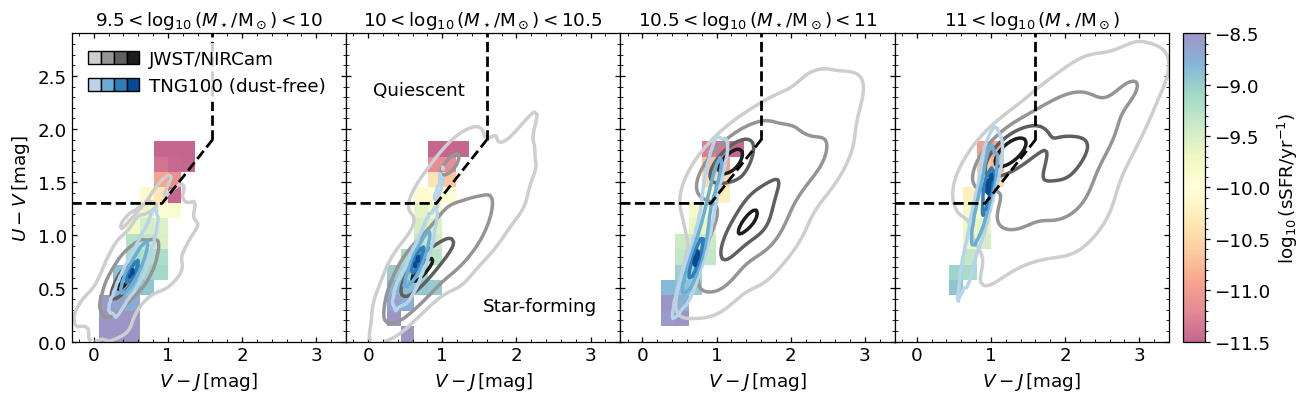

In [7]:
# Figure 2

datasets = Datasets([JWST_NIRCam, TNG100])
datasets.plotUVJdiagram([0, 1], ['Mag_UVJ', 'Mag_UVJ_SKIRT_fDust0_BPASS'], ['Greys', 'Blues'], ['JWST/NIRCam', 'TNG100 (dust-free)'],
    addCategoryText = True, colorCodingIndices = 1)

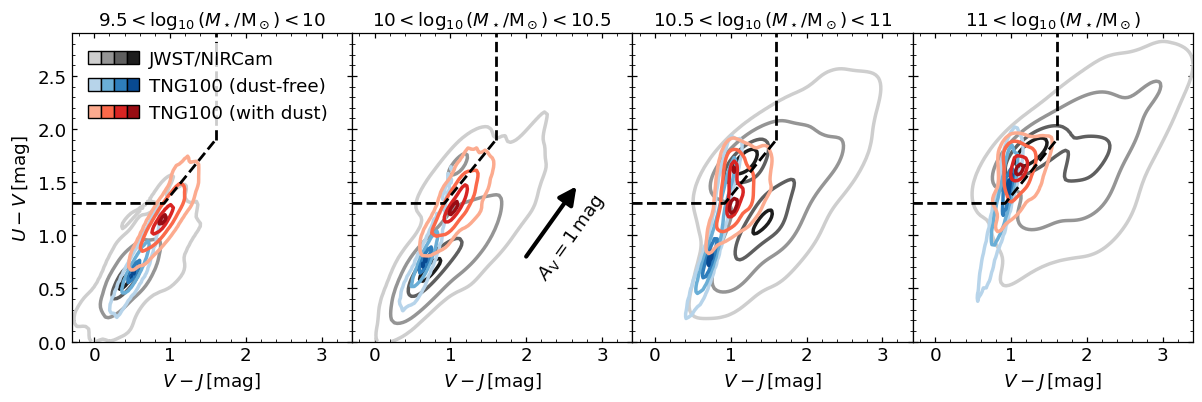

In [8]:
# Figure 3

datasets = Datasets([JWST_NIRCam, TNG100])
datasets.plotUVJdiagram([0, 1, 1], ['Mag_UVJ', 'Mag_UVJ_SKIRT_fDust0_BPASS', 'Mag_UVJ_SKIRT_fDust05_BPASS_TODDLERS_THEMIS'],
    ['Greys', 'Blues', 'Reds'], ['JWST/NIRCam', 'TNG100 (dust-free)', 'TNG100 (with dust)'], showAvArrow = True)

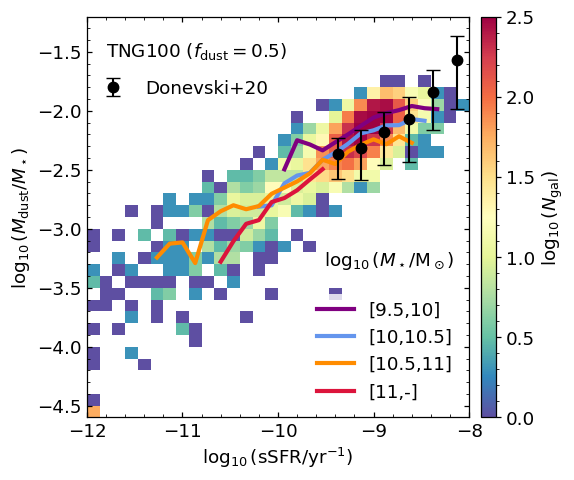

In [9]:
# Figure 4

xmin = -12. # Minimum log10(sSFR)
xmax = -8. # Maximum log10(sSFR)
ymin = -4.6 # Minimum log10(Mdust/Mstar)
ymax = -1.6 # Maximum log10(Mdust/Mstar)
Nbins = 30 # Number of bins

xBins = np.linspace(xmin, xmax, Nbins + 1)
yBins = np.linspace(ymin, ymax, Nbins + 1)
xBinMidpoints = (xBins[:-1] + xBins[1:]) / 2.

fDust = 0.5 # Dust-to-metal ratio for TNG100 galaxies (default: 0.5)
logmstarBins = np.array([9.5, 10., 10.5, 11., np.inf]) # Stellar mass bins for the running medians
colorList = ['purple', 'cornflowerblue', 'darkorange', 'crimson']
labelList = ['[9.5,10]', '[10,10.5]', '[10.5,11]', '[11,-]']

# Observational data from Donevski et al. 2020 (star-forming galaxies)
# Acquired via WebPlotDigitizer :)

logsSFR_Donevski20 = np.array([-9.377005347593581, -9.12673796791444, -8.886096256684494, -8.626203208556149, -8.375935828877006, -8.12566844919786])
logspecificDustMass_Donevski20 = np.log10(np.array([0.004275384155343527, 0.0047938930021527455, 0.00658196609056587, 0.008496778601671692, 0.014538643940772348, 0.026928386065539236]))
errorUp_Donevski20 = np.log10(np.array([0.005870058743901308, 0.006939052785752003, 0.00969651511501626, 0.01319650391727287, 0.022186066271559897, 0.04332227761735856])) - logspecificDustMass_Donevski20
errorDown_Donevski20 = logspecificDustMass_Donevski20 - np.log10(np.array([0.002657505594014445, 0.002611115025074856, 0.0034915722445043383, 0.0037135534137327417, 0.006939052785751854, 0.010312983459917414]))

# Make the figure

fig = plt.figure(figsize = (6., 5.))
ax = fig.add_subplot(111)

with np.errstate(divide = 'ignore'):
    logsSFR_TNG100 = np.clip(np.log10(TNG100.getsSFR()), a_min = xmin, a_max = xmax)
    logspecificDustMass_TNG100 = np.clip(np.log10(TNG100.data['mmetals'] * fDust / TNG100.data['mstar']), a_min = ymin, a_max = ymax)


# Plot the 2D distributions

hist = np.histogram2d(logsSFR_TNG100, logspecificDustMass_TNG100, bins = (xBins, yBins))[0]

with np.errstate(divide = 'ignore'):

    im = ax.pcolormesh(xBins, yBins, np.log10(hist.T), cmap = 'Spectral_r', vmin = 0., vmax = 2.5)

# Also plot running medians in stellar mass bins

for idxMstar in range(len(logmstarBins) - 1):
    runningMedian = []

    SEL_Mstar = (TNG100.getLogmstar() >= logmstarBins[idxMstar]) * (TNG100.getLogmstar() < logmstarBins[idxMstar + 1])

    for idx_sSFR in range(Nbins):
        
        SEL_sSFR = (logsSFR_TNG100 >= xBins[idx_sSFR]) * (logsSFR_TNG100 < xBins[idx_sSFR + 1])

        Ngal_inBin = len(logspecificDustMass_TNG100[SEL_Mstar * SEL_sSFR])

        if Ngal_inBin <= 5:
            runningMedian.append(np.nan)

        else:
            runningMedian.append(np.median(logspecificDustMass_TNG100[SEL_Mstar * SEL_sSFR]))
    
    ax.plot(xBinMidpoints, runningMedian, color = colorList[idxMstar], label = labelList[idxMstar], linewidth = 3.)

lg0 = ax.legend(loc = 'lower right')
lg0.get_frame().set_linewidth(0.)
ax.add_artist(lg0)

cax = ax.inset_axes([1.03, 0., 0.04, 1.])
cbar = plt.colorbar(im, cax = cax)
cbar.minorticks_on()
cbar.set_label(r'$\log_{10}(N_\mathrm{gal})$')

ax.text(x = 0.05, y = 0.9, s = r'TNG100 ($f_\mathrm{dust}=0.5$)', transform = ax.transAxes)

ax.text(x = 0.62, y = 0.38, s = r'$\log_{10}(M_\star/\mathrm{M}_\odot)$', transform = ax.transAxes)

# Plot the observational results

marker = ax.errorbar(logsSFR_Donevski20, logspecificDustMass_Donevski20, yerr = (errorDown_Donevski20, errorUp_Donevski20),
     color = 'black', ls = 'none', capsize = 5., marker = 'o', markersize = 7.5, label = 'Donevski+20')

lg1 = ax.legend(handles = [marker], loc = (0., 0.78))
lg1.get_frame().set_linewidth(0.)
lg1.get_frame().set_alpha(0.)

ax.set_xlabel(r'$\log_{10}(\mathrm{sSFR/\mathrm{yr}^{-1}})$')
ax.set_ylabel(r'$\log_{10}(M_\mathrm{dust}/M_\star)$')

ax.tick_params(which = 'both', direction = 'in', top = True, right = True)
ax.minorticks_on()

plt.tight_layout()

plt.show()
plt.close()

131 massive, star-forming TNG100 galaxies in this selection.
162 massive, star-forming galaxies in the observational sample in this selection.
Median value for property 0 for dataset 0 : 2.012
Median value for property 0 for dataset 1 : 1.106
Median value for property 0 for dataset 2 : 0.901
Median value for property 1 for dataset 0 : 1.721
Median value for property 1 for dataset 1 : 1.608
Median value for property 1 for dataset 2 : 1.316
Median value for property 2 for dataset 0 : -22.025
Median value for property 2 for dataset 1 : -23.61
Median value for property 2 for dataset 2 : -24.077


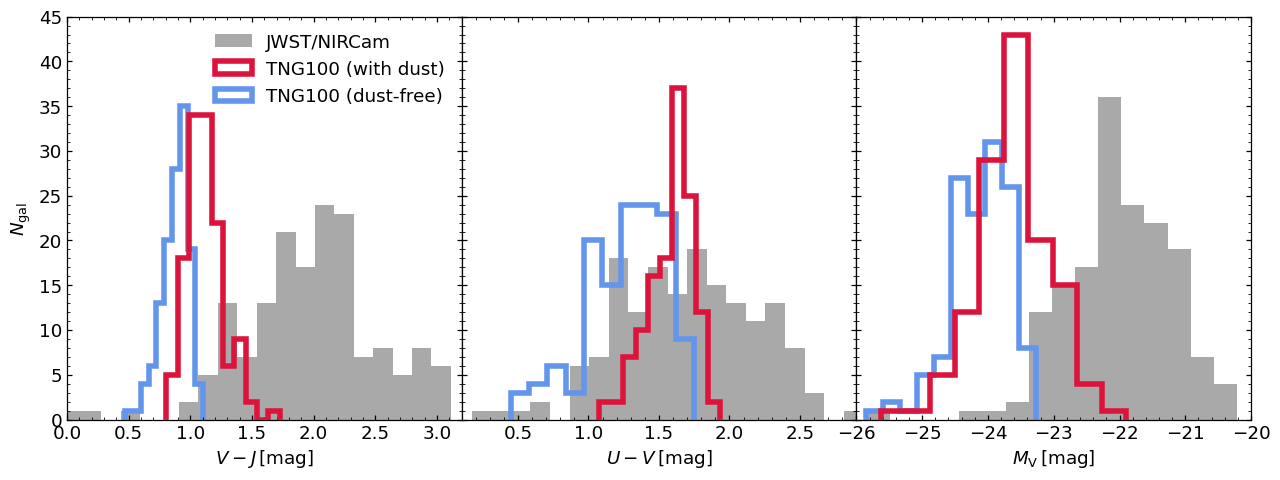

In [10]:
# Figure 5

logmstar_min = 11.
logsSFR_min = -10.6

VJ_DJA_all = JWST_NIRCam.data['Mag_UVJ'][:, 1] - JWST_NIRCam.data['Mag_UVJ'][:, 2]
UV_DJA_all = JWST_NIRCam.data['Mag_UVJ'][:, 0] - JWST_NIRCam.data['Mag_UVJ'][:, 1]

with np.errstate(divide = 'ignore'):
    SEL_TNG100 = (TNG100.getLogmstar() >= logmstar_min) * (np.log10(TNG100.getsSFR()) >= logsSFR_min)
SEL_DJA = (JWST_NIRCam.getLogmstar() >= logmstar_min) * ((UV_DJA_all <= 1.3) + (UV_DJA_all <= (0.88 * VJ_DJA_all + 0.49)) + (VJ_DJA_all >= 1.6))

print(len(SEL_TNG100[SEL_TNG100]), 'massive, star-forming TNG100 galaxies in this selection.')
print(len(SEL_DJA[SEL_DJA]), 'massive, star-forming galaxies in the observational sample in this selection.')

# Make the plot

VJ_min = 0.
VJ_max = 3.2
UV_min = 0.1
UV_max = 2.9
V_min = -26.
V_max = -20.

Nbins = 20
sigmaSmoothing = 1.5

min_list = [VJ_min, UV_min, V_min]
max_list = [VJ_max, UV_max, V_max]

colorList = ['darkgrey', 'crimson', 'cornflowerblue']
labelList = ['JWST/NIRCam', 'TNG100 (with dust)', 'TNG100 (dust-free)']

Mag_UVJ_DJA = JWST_NIRCam.data['Mag_UVJ'][SEL_DJA, :]
Mag_UVJ_TNG100_fDust05 = TNG100.data['Mag_UVJ_SKIRT_fDust05_BPASS_TODDLERS_THEMIS'][SEL_TNG100, :]
Mag_UVJ_TNG100_fDust0 = TNG100.data['Mag_UVJ_SKIRT_fDust0_BPASS'][SEL_TNG100, :]

VJ_list = [Mag_UVJ_DJA[:, 1] - Mag_UVJ_DJA[:, 2], Mag_UVJ_TNG100_fDust05[:, 1] - Mag_UVJ_TNG100_fDust05[:, 2], Mag_UVJ_TNG100_fDust0[:, 1] - Mag_UVJ_TNG100_fDust0[:, 2]]
UV_list = [Mag_UVJ_DJA[:, 0] - Mag_UVJ_DJA[:, 1], Mag_UVJ_TNG100_fDust05[:, 0] - Mag_UVJ_TNG100_fDust05[:, 1], Mag_UVJ_TNG100_fDust0[:, 0] - Mag_UVJ_TNG100_fDust0[:, 1]]
V_list = [Mag_UVJ_DJA[:, 1], Mag_UVJ_TNG100_fDust05[:, 1], Mag_UVJ_TNG100_fDust0[:, 1]]

data_list = [VJ_list, UV_list, V_list]

histtypeList = ['stepfilled', 'step', 'step']
NbinsList = [20, 10, 10]
zorderList = [-10., 10., 0.]

fig, axes = plt.subplots(figsize = (13., 5.), nrows = 1, ncols = 3)

for idx_panel in range(3):

    bins = np.linspace(min_list[idx_panel], max_list[idx_panel], Nbins + 1)
    binMidpoints = (bins[:-1] + bins[1:]) / 2.

    for idx_data in range(3):

        data = data_list[idx_panel][idx_data]
        axes[idx_panel].hist(data, NbinsList[idx_data], histtype = histtypeList[idx_data], linewidth = 4., color = colorList[idx_data],
            label = labelList[idx_data], zorder = zorderList[idx_data])

        print('Median value for property', idx_panel, 'for dataset', idx_data, ':', np.round(np.median(data), 3))

lg = axes[0].legend(loc = 'upper right')
lg.get_frame().set_linewidth(0.)
lg.get_frame().set_alpha(0.)

axes[0].set_xlabel(r'$V-J\,[\mathrm{mag}]$')
axes[1].set_xlabel(r'$U-V\,[\mathrm{mag}]$')
axes[2].set_xlabel(r'$M_\mathrm{V}\,[\mathrm{mag}]$')

axes[0].set_ylabel(r'$N_\mathrm{gal}$')

for idx, ax in enumerate(axes):

    ax.set_xlim(min_list[idx], max_list[idx])
    ax.set_ylim(0., 45)

    ax.tick_params(which='both', direction='in', top=True, right=True)
    ax.minorticks_on()

axes[1].set_yticklabels([])
axes[2].set_yticklabels([])

plt.tight_layout()

plt.subplots_adjust(wspace = 0.)

plt.show()
plt.close()

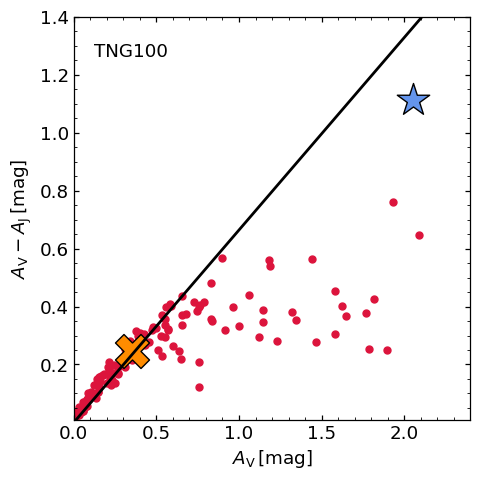

In [11]:
# Figure 6

logmstar_min = 11.
logsSFR_min = -10.6

VJ_DJA_all = JWST_NIRCam.data['Mag_UVJ'][:, 1] - JWST_NIRCam.data['Mag_UVJ'][:, 2]
UV_DJA_all = JWST_NIRCam.data['Mag_UVJ'][:, 0] - JWST_NIRCam.data['Mag_UVJ'][:, 1]

with np.errstate(divide = 'ignore'):
    SEL_TNG100 = (TNG100.getLogmstar() >= logmstar_min) * (np.log10(TNG100.getsSFR()) >= logsSFR_min)

SEL_DJA = (JWST_NIRCam.getLogmstar() >= logmstar_min) * ((UV_DJA_all <= 1.3) + (UV_DJA_all <= (0.88 * VJ_DJA_all + 0.49)) + (VJ_DJA_all >= 1.6))

Mag_UVJ_TNG100 = TNG100.data['Mag_UVJ_SKIRT_fDust05_BPASS_TODDLERS_THEMIS'][SEL_TNG100, :]
Mag_UVJ_TNG100_dustfree = TNG100.data['Mag_UVJ_SKIRT_fDust0_BPASS'][SEL_TNG100, :]
Mag_UVJ_DJA = JWST_NIRCam.data['Mag_UVJ'][SEL_DJA, :]

AV_TNG100 = Mag_UVJ_TNG100[:, 1] - Mag_UVJ_TNG100_dustfree[:, 1]
AJ_TNG100 = Mag_UVJ_TNG100[:, 2] - Mag_UVJ_TNG100_dustfree[:, 2]


# Compute the values of A_V and A_V - A_J that would be required to reproduce the observational data

AV_required = np.median(Mag_UVJ_DJA[:, 1]) - np.median(Mag_UVJ_TNG100_dustfree[:, 1])
AVminusAJ_required = np.median(Mag_UVJ_DJA[:, 1] - Mag_UVJ_DJA[:, 2]) - np.median(Mag_UVJ_TNG100_dustfree[:, 1] - Mag_UVJ_TNG100_dustfree[:, 2])

# Create the plot

AV_grid = np.linspace(0., 2.4, 1000)

fig = plt.figure(figsize = (5., 5.))
ax = fig.add_subplot(111)

ax.scatter(AV_TNG100, AV_TNG100 - AJ_TNG100, color = 'crimson', marker = 'o', s = 25.)

ax.scatter(np.median(AV_TNG100), np.median(AV_TNG100 - AJ_TNG100), color = 'darkorange', edgecolors = 'black', marker = 'X', s = 600.)


ax.plot(AV_grid, 0.664 * AV_grid, color = 'black', linewidth = 2., label = 'Screen') # The THEMIS extinction law

# Plot the A_V / A_V - A_J values that are required to reproduce the observational data

ax.scatter(AV_required, AVminusAJ_required, color = 'cornflowerblue', edgecolors = 'black', marker = '*', s = 600.)

ax.text(x = 0.05, y = 0.9, s = 'TNG100', transform = ax.transAxes)

ax.set_xlim(0., 2.4)
ax.set_ylim(1e-2, 1.4)

ax.set_xlabel(r'$A_\mathrm{V}\,[\mathrm{mag}]$')
ax.set_ylabel(r'$A_\mathrm{V}-A_\mathrm{J}\,[\mathrm{mag}]$')

ax.tick_params(which='both', direction='in', top=True, right=True)
ax.minorticks_on()

plt.tight_layout()
plt.show()
plt.close()

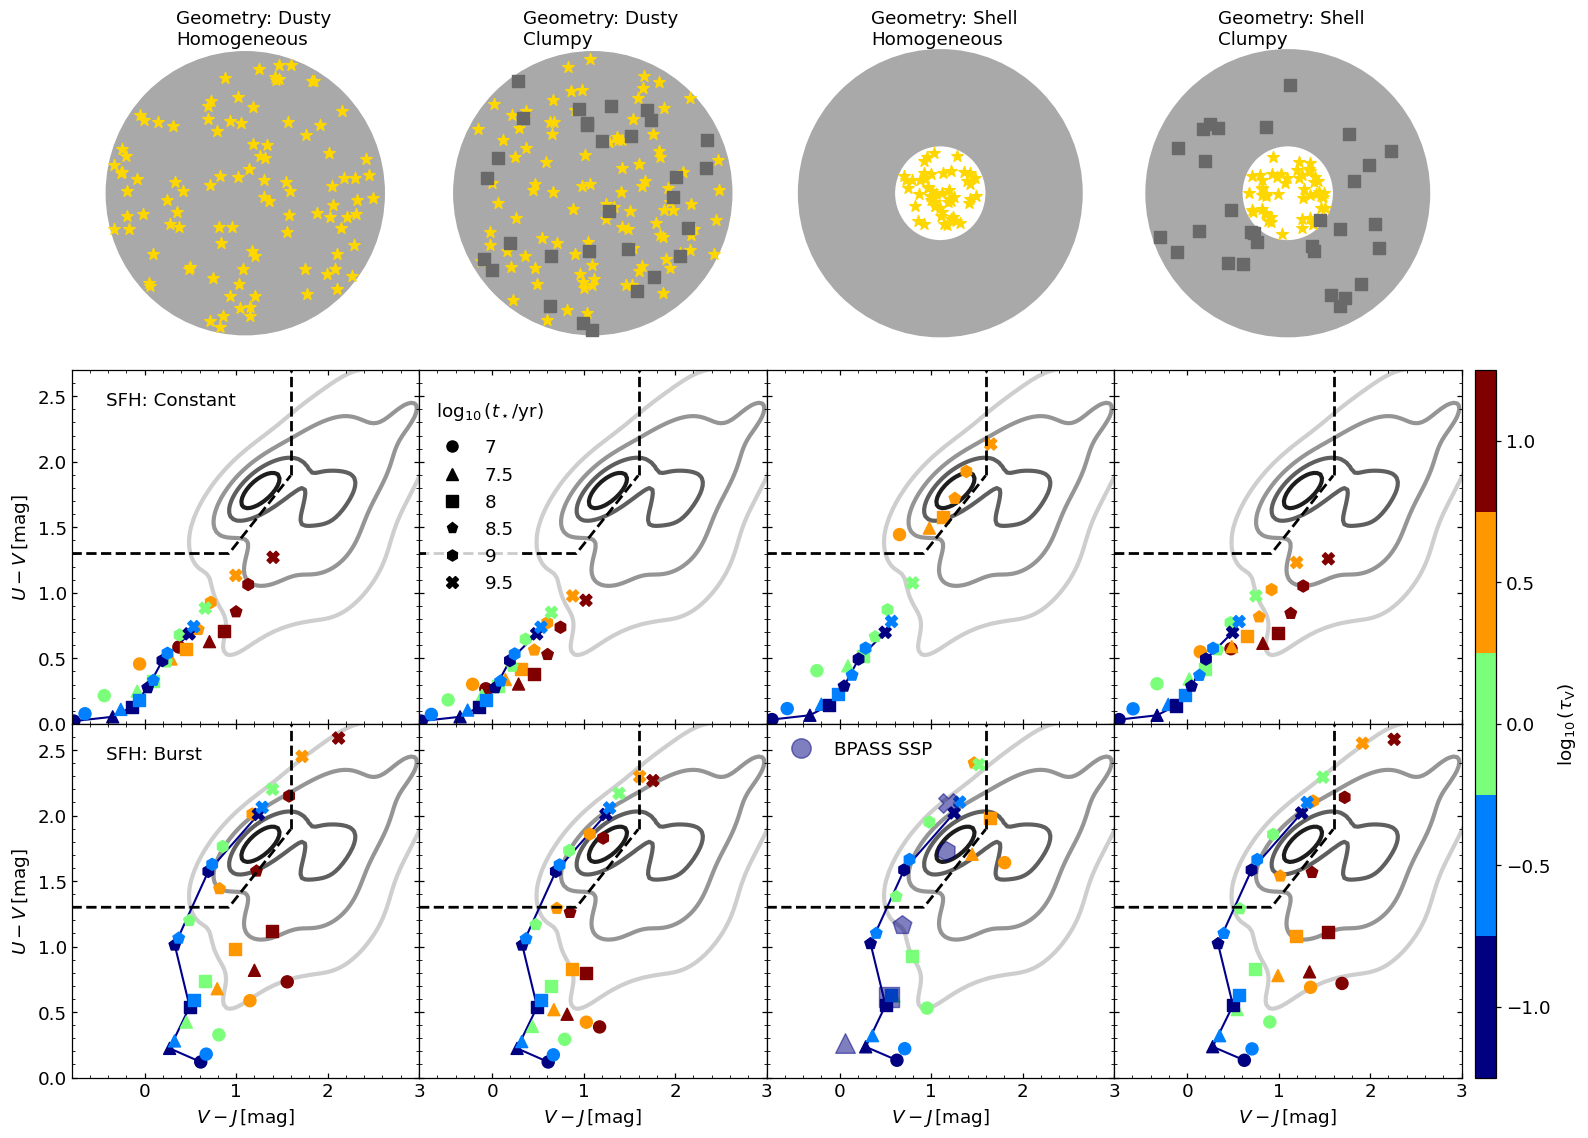

In [12]:
# Figure 7

# Get the JWST NIRCam data

datasets = Datasets([JWST_NIRCam])

SELmassive = (JWST_NIRCam.getLogmstar() >= 11.)

VJ = JWST_NIRCam.data['Mag_UVJ'][SELmassive, 1] - JWST_NIRCam.data['Mag_UVJ'][SELmassive, 2]
UV = JWST_NIRCam.data['Mag_UVJ'][SELmassive, 0] - JWST_NIRCam.data['Mag_UVJ'][SELmassive, 1]

data_xx, data_yy, data_KDE, data_KDElevels = datasets.computeKDE(VJ, UV)
cmap_data = matplotlib.colormaps['Greys']
cmapValues = [0.3, 0.5, 0.7, 0.9]

# Read in the DIRTY colors

with h5py.File('data/DIRTY.hdf5') as f:

    ages_DIRTY = f.attrs['age'] * 1e6 # Stellar ages in years

    VminusJ_DIRTY = f['Mag_VminusJ'][:] # AB magnitude colors. Shape of the array: geometry, SFH type, stellar age, dust optical depth
    UminusV_DIRTY = f['Mag_UminusV'][:] # AB magnitude colors. Shape of the array: geometry, SFH type, stellar age, dust optical depth


# Run through stellar age and dust optical depth
indices_age = [12, 18, 24, 30, 36, 42] # log10(stellar age / Myr) = (1, 1.5, 2, 2.5, 3, 3.5)
indices_tau = [0, 6, 12, 18, 24] # log10(tau_dust) = (-1, -0.5, 0, 0.5, 1)



markerList = ['o', '^', 's', 'p', 'h', 'X']
labelList = [7, 7.5, 8, 8.5, 9, 9.5]

# Different panels for the geometries / SFH types
indices_geometry = [4, 1, 5, 2] # dusty (homogeneous), dusty (clumpy), shell (homogeneous), shell (clumpy)
indices_sftype = [1, 0] # const, burst

cmap_DIRTY = plt.get_cmap('jet', 5)    # 5 discrete colors

fig, axes = plt.subplots(figsize = (16., 11.6), nrows = 3, ncols = 4)


for idx_i in range(2):
    for idx_j in range(4):

        idx = idx_j + 4 * idx_i
        handles = []

        for idx_age in range(6):

            VJ = VminusJ_DIRTY[indices_geometry[idx_j], indices_sftype[idx_i], indices_age[idx_age], indices_tau] # V-J as a funciton of optical depth (1D array)
            UV = UminusV_DIRTY[indices_geometry[idx_j], indices_sftype[idx_i], indices_age[idx_age], indices_tau] # U-V as a funciton of optical depth (1D array)

            im = axes[idx_i + 1, idx_j].scatter(VJ, UV, s = 75., c = np.linspace(-1.25, 1.25, 5), marker = markerList[idx_age], cmap = cmap_DIRTY)

            handles.append(Line2D([], [], color = 'black', marker = markerList[idx_age], linestyle = 'None', markersize = 8., label = labelList[idx_age]))


        axes[idx_i + 1, idx_j].plot(VminusJ_DIRTY[indices_geometry[idx_j], indices_sftype[idx_i], indices_age, indices_tau[0]],
            UminusV_DIRTY[indices_geometry[idx_j], indices_sftype[idx_i], indices_age, indices_tau[0]], color = 'darkblue', zorder = -5., linewidth = 1.5)
        
        # Plot the JWST NIRCam data

        axes[idx_i + 1, idx_j].contour(data_xx, data_yy, data_KDE, levels = data_KDElevels,
           colors = [cmap_data(i) for i in cmapValues], linewidths = 3., zorder = -10.)

        if idx == 5:
            lg = axes[1, 1].legend(loc = (0.02, 0.35), handles = handles)
            lg.get_frame().set_linewidth(0.)

        if idx == 7:
            cax = axes[-1, -1].inset_axes([1.04, 0., 0.06, 2.])
            cbar = plt.colorbar(im, cax = cax, ticks = [-1., -0.5, 0., 0.5, 1.])
            cbar.set_label(r'$\log_{10}(\tau_\mathrm{V})$')

        # Plot the demarcation line

        VJ_Williams = np.linspace(-0.8, 3., 1000)
        UV_Williams = np.where(VJ_Williams <= 1.6, np.clip(0.88 * VJ_Williams + 0.49, a_min = 1.3, a_max = None), np.inf)

        axes[idx_i + 1, idx_j].plot(VJ_Williams, UV_Williams, linestyle = '--', color = 'black', linewidth = 2.)
        axes[idx_i + 1, idx_j].vlines(1.6, 0.88 * 1.6 + 0.49, 3., linestyle = '--', color = 'black', linewidth = 2.)


axes[1, 1].text(x = 0.05, y = 0.87, s = r'$\log_{10}(t_\star/\mathrm{yr})$', transform = axes[1, 1].transAxes)

axes[1, 0].text(x = 0.1, y = 0.9, s = 'SFH: Constant', color = 'black', transform = axes[1, 0].transAxes)
axes[2, 0].text(x = 0.1, y = 0.9, s = 'SFH: Burst', color = 'black', transform = axes[2, 0].transAxes)

# Plot the BPASS values

# Load the BPASS SSP fluxes and generate interpolating functions

BPASS_file = np.loadtxt('data/BPASSfluxes.txt')
SSP_Z = np.unique(BPASS_file[:, 0])
SSP_age = np.unique(BPASS_file[:, 1])
SSP_flux_U = BPASS_file[:, 2].reshape((len(SSP_Z), len(SSP_age)))
SSP_flux_V = BPASS_file[:, 3].reshape((len(SSP_Z), len(SSP_age)))
SSP_flux_J = BPASS_file[:, 4].reshape((len(SSP_Z), len(SSP_age)))

# Logarithmic interpolation
flux_U_function = RegularGridInterpolator((np.log10(SSP_Z), np.log10(SSP_age)), np.log10(SSP_flux_U))
flux_V_function = RegularGridInterpolator((np.log10(SSP_Z), np.log10(SSP_age)), np.log10(SSP_flux_V))
flux_J_function = RegularGridInterpolator((np.log10(SSP_Z), np.log10(SSP_age)), np.log10(SSP_flux_J))


# Compute BPASS colors at solar metallicity (metal mass fraction = 0.02) and specific ages which correspond to the chosen values in the DIRTY parameter space
Z_BPASS = 0.02 # Metal mass fraction
UV_BPASS = -2.5 * np.log10(10**flux_U_function((np.log10(Z_BPASS), np.log10(ages_DIRTY[indices_age]))) / 10**flux_V_function((np.log10(Z_BPASS), np.log10(ages_DIRTY[indices_age]))))
VJ_BPASS = -2.5 * np.log10(10**flux_V_function((np.log10(Z_BPASS), np.log10(ages_DIRTY[indices_age]))) / 10**flux_J_function((np.log10(Z_BPASS), np.log10(ages_DIRTY[indices_age]))))


for idx_age in range(6):
    axes[2, 2].scatter(VJ_BPASS[idx_age], UV_BPASS[idx_age], color = cmap_DIRTY(0), s = 200., marker = markerList[idx_age], alpha = 0.5)
    

handles_BPASS = [Line2D([], [], color = cmap_DIRTY(0), marker = 'o', alpha = 0.5, linestyle = 'None', markersize = 14., label = 'BPASS SSP')]
lg_BPASS = axes[2, 2].legend(loc = 'upper left', handles = handles_BPASS)
lg_BPASS.get_frame().set_linewidth(0.)

# Plot the geometry sketches

N_denseDust = 30

outer_radius = 0.39
inner_radius = 0.3 * outer_radius

geometryLabels = ['Geometry: Dusty', 'Geometry: Dusty', 'Geometry: Shell', 'Geometry: Shell']
clumpinessLabels = ['Homogeneous', 'Clumpy', 'Homogeneous', 'Clumpy']


for idx in range(4):

    axes[0, idx].text(x = 0.3, y = 0.98, s = geometryLabels[idx], color = 'black', transform = axes[0, idx].transAxes)
    axes[0, idx].text(x = 0.3, y = 0.92, s = clumpinessLabels[idx], color = 'black', transform = axes[0, idx].transAxes)

    if idx <= 1:
        circle = plt.Circle((0.5, 0.5), 0.4, color = 'darkgrey', transform = axes[0, idx].transAxes)
        outer_r_stars = outer_radius
        N_stars = 100
    else:
        circle = plt.Circle((0.5, 0.5), 0.27, color = 'darkgrey', fill = False, linewidth = 70., transform = axes[0, idx].transAxes)
        outer_r_stars = inner_radius
        N_stars = 50

    x_stars = []
    y_stars = []

    while True:

        if len(x_stars) == N_stars: # Check if we have enough star markers
            break 

        x_star = np.random.uniform(-0.5, 0.5)
        y_star = np.random.uniform(-0.5, 0.5)
        r_star = np.sqrt(x_star**2 + y_star**2)

        if r_star <= outer_r_stars:
            x_stars.append(x_star)
            y_stars.append(y_star)  

    axes[0, idx].add_patch(circle)

    axes[0, idx].scatter(np.array(x_stars) + 0.5, np.array(y_stars) + 0.5, transform = axes[0, idx].transAxes, marker = '*', color = 'gold', s = 75.)

    if idx == 1 or idx == 3: # Add dust clumps

        if idx == 1:
            outer_radius_dust = outer_radius
            inner_radius_dust = 0.
        
        else:
            outer_radius_dust = outer_radius
            inner_radius_dust = inner_radius
            

        x_denseDust = []
        y_denseDust = []

        while True:

            if len(x_denseDust) == N_denseDust: # Check if we have enough star markers
                break 

            x_dust = np.random.uniform(-0.5, 0.5)
            y_dust = np.random.uniform(-0.5, 0.5)
            r_dust = np.sqrt(x_dust**2 + y_dust**2)

            if inner_radius_dust <= r_dust and r_dust <= outer_radius:
                x_denseDust.append(x_dust)
                y_denseDust.append(y_dust)  


        axes[0, idx].scatter(np.array(x_denseDust) + 0.5, np.array(y_denseDust) + 0.5, transform = axes[0, idx].transAxes, marker = 's', color = 'dimgrey', s = 75.)

    for spine in axes[0, idx].spines.values():
        spine.set_visible(False) 

    axes[0, idx].get_xaxis().set_ticks([])
    axes[0, idx].get_yaxis().set_ticks([])



axes[2, 0].set_xlabel(r'$V-J\,[\mathrm{mag}]$')
axes[2, 1].set_xlabel(r'$V-J\,[\mathrm{mag}]$')
axes[2, 2].set_xlabel(r'$V-J\,[\mathrm{mag}]$')
axes[2, 3].set_xlabel(r'$V-J\,[\mathrm{mag}]$')
axes[1, 0].set_ylabel(r'$U-V\,[\mathrm{mag}]$')
axes[2, 0].set_ylabel(r'$U-V\,[\mathrm{mag}]$')

axes[1, 1].set_yticklabels([])
axes[2, 1].set_yticklabels([])
axes[1, 2].set_yticklabels([])
axes[2, 2].set_yticklabels([])
axes[1, 3].set_yticklabels([])
axes[2, 3].set_yticklabels([])
axes[1, 3].set_xticklabels([])

for ax in axes.flatten():

    ax.set_xlim(-0.8, 3.)
    ax.set_ylim(0., 2.7)

    ax.tick_params(which = 'both', direction = 'in', top = True, right = True)
    ax.minorticks_on()

plt.tight_layout()
plt.subplots_adjust(hspace = 0., wspace = 0.)
plt.show()

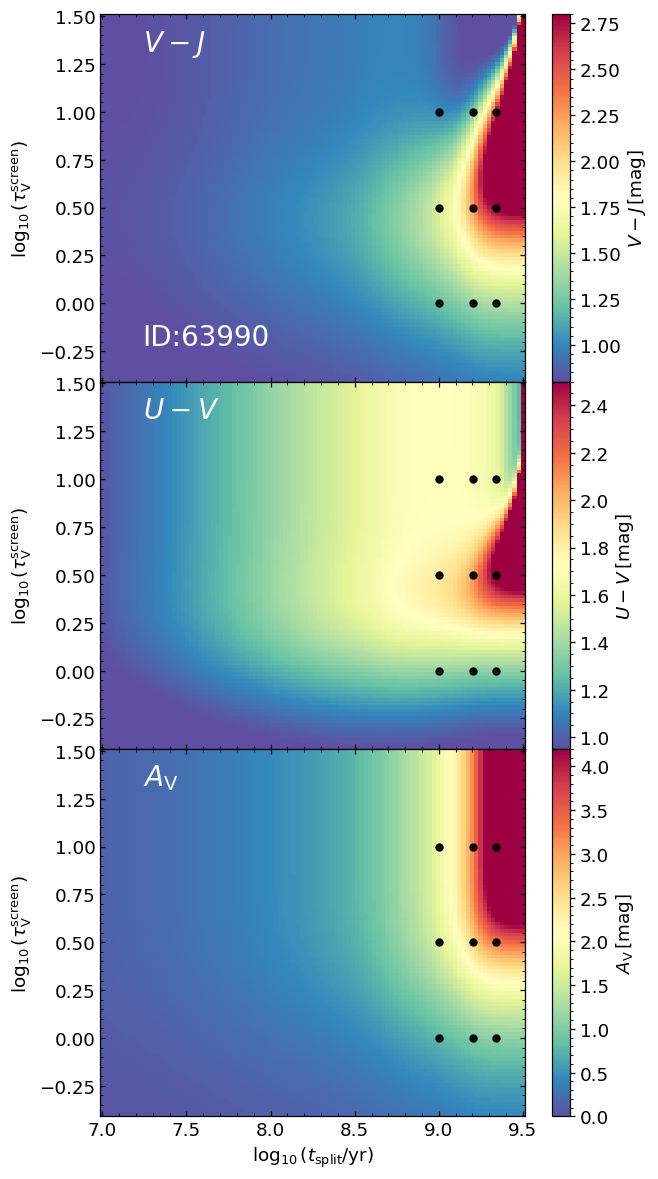

In [13]:
# Figure 8

with h5py.File('data/TNG100ToyModel.hdf5') as f:

    IDs = f['SubhaloID'][:]
    ID = f.attrs['ID_singleGalaxy']

    SEL = (IDs == ID)

    Mag_UVJ_TNG100ToyModel_dustFree = f['Mag_UVJ_dustFree'][SEL, :][0, :]
    Mag_UVJ_TNG100ToyModel = f['Mag_UVJ_singleGalaxy'][:]

    logAge = np.log10(f.attrs['ageSplit_singleGalaxy'])
    logTau = np.log10(f.attrs['tau_singleGalaxy'])

    logAge_coarseGrid = np.log10(f.attrs['ageSplit'])
    logTau_coarseGrid = np.log10(f.attrs['tau'])

VminusJ = Mag_UVJ_TNG100ToyModel[:, :, 1] - Mag_UVJ_TNG100ToyModel[:, :, 2]
UminusV = Mag_UVJ_TNG100ToyModel[:, :, 0] - Mag_UVJ_TNG100ToyModel[:, :, 1]
AV = Mag_UVJ_TNG100ToyModel[:, :, 1] - Mag_UVJ_TNG100ToyModel_dustFree[None, None, 1]


fig, axes = plt.subplots(figsize = (6.5, 12.), nrows = 3, ncols = 1)

im0 = axes[0].pcolormesh(logAge, logTau, VminusJ.T, cmap = 'Spectral_r', vmin = 0.8, vmax = 2.8)
im1 = axes[1].pcolormesh(logAge, logTau, UminusV.T, cmap = 'Spectral_r', vmin = 0.95, vmax = 2.5)
im2 = axes[2].pcolormesh(logAge, logTau, AV.T, cmap = 'Spectral_r', vmin = 0., vmax = 4.2)

logAge_2D, logTau_2D = np.meshgrid(logAge_coarseGrid, logTau_coarseGrid, indexing = 'ij')
for idx in range(3):
    axes[idx].scatter(logAge_2D, logTau_2D, color = 'black', s = 25.)

cbar0 = plt.colorbar(im0, ax = axes[0])
cbar0.minorticks_on()
cbar0.set_label(r'$V-J\,[\mathrm{mag}]$')

cbar1 = plt.colorbar(im1, ax = axes[1])
cbar1.minorticks_on()
cbar1.set_label(r'$U-V\,[\mathrm{mag}]$')

cbar2 = plt.colorbar(im2, ax = axes[2])
cbar2.minorticks_on()
cbar2.set_label(r'$A_\mathrm{V}\,[\mathrm{mag}]$')

axes[2].set_xlabel(r'$\log_{10}(t_\mathrm{split}/\mathrm{yr})$')
axes[0].set_ylabel(r'$\log_{10}(\tau_\mathrm{V}^\mathrm{screen})$')
axes[1].set_ylabel(r'$\log_{10}(\tau_\mathrm{V}^\mathrm{screen})$')
axes[2].set_ylabel(r'$\log_{10}(\tau_\mathrm{V}^\mathrm{screen})$')


axes[0].text(x = 0.1, y = 0.1, s = 'ID:' + str(ID), color = 'white', transform = axes[0].transAxes, fontsize = 20.)

axes[0].text(x = 0.1, y = 0.9, s = r'$V-J$', color = 'white', transform = axes[0].transAxes, fontsize = 20.)
axes[1].text(x = 0.1, y = 0.9, s = r'$U-V$', color = 'white', transform = axes[1].transAxes, fontsize = 20.)
axes[2].text(x = 0.1, y = 0.9, s = r'$A_\mathrm{V}$', color = 'white', transform = axes[2].transAxes, fontsize = 20.)

for ax in axes:

    ax.tick_params(which = 'both', direction = 'in', top = True, right = True)
    ax.minorticks_on()

axes[0].set_xticklabels([])
axes[1].set_xticklabels([])

plt.tight_layout()
plt.subplots_adjust(hspace = 0.)
plt.show()
plt.close()


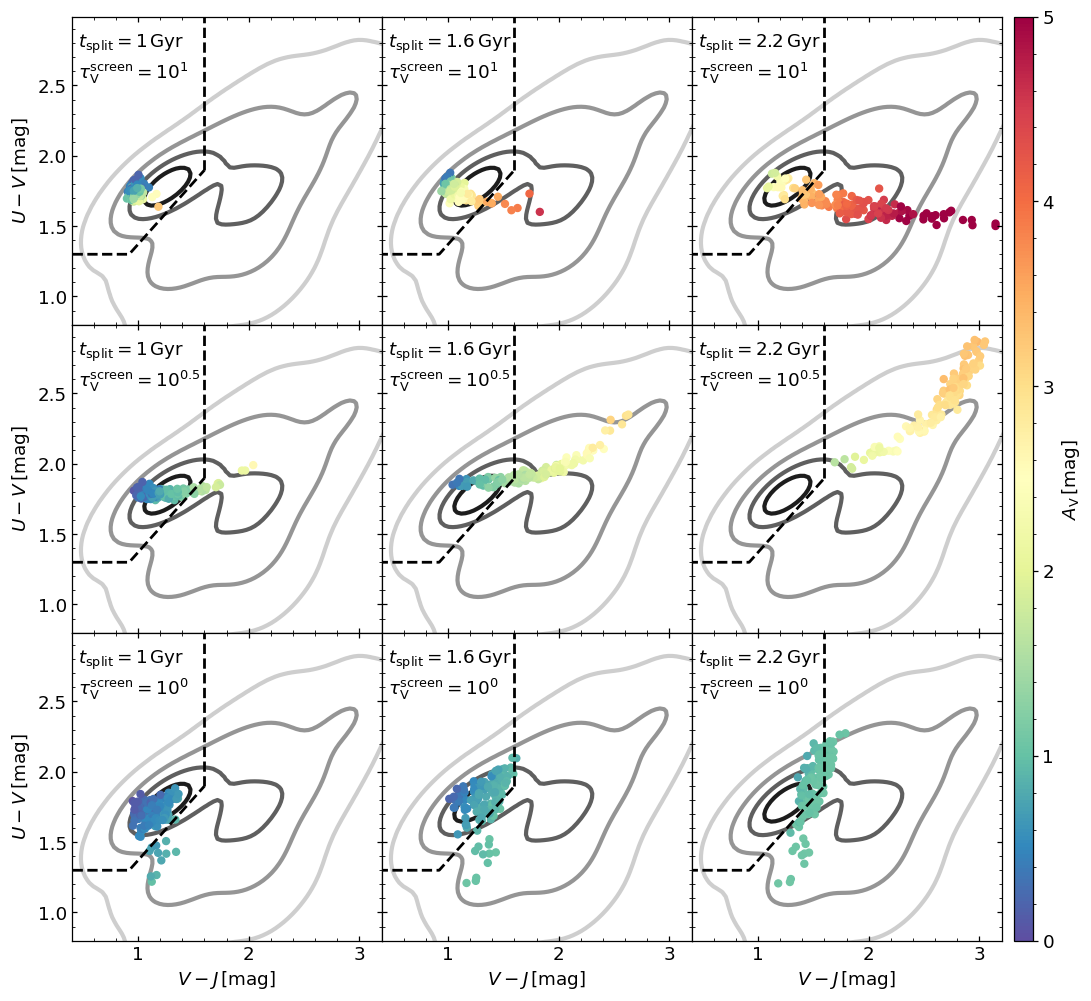

In [14]:
# Figure 9


# Get the JWST NIRCam data

datasets = Datasets([JWST_NIRCam])

SELmassive = (JWST_NIRCam.getLogmstar() >= 11.)

VJ = JWST_NIRCam.data['Mag_UVJ'][SELmassive, 1] - JWST_NIRCam.data['Mag_UVJ'][SELmassive, 2]
UV = JWST_NIRCam.data['Mag_UVJ'][SELmassive, 0] - JWST_NIRCam.data['Mag_UVJ'][SELmassive, 1]

data_xx, data_yy, data_KDE, data_KDElevels = datasets.computeKDE(VJ, UV)
cmap_data = matplotlib.colormaps['Greys']
cmapValues = [0.3, 0.5, 0.7, 0.9]

# Get the Toy model data

with h5py.File('data/TNG100ToyModel.hdf5') as f:

    IDs = f['SubhaloID'][:]

    Mag_UVJ_TNG100ToyModel_dustFree = f['Mag_UVJ_dustFree'][:]
    Mag_UVJ_TNG100ToyModel = f['Mag_UVJ'][:]

    tau_TNG100ToyModel = np.log10(f.attrs['tau'])
    ageSplit_TNG100ToyModel = f.attrs['ageSplit'] * 1e-9 # In Gyr

ageSplit_TNG100ToyModel = [r'$t_\mathrm{split}=1\,\mathrm{Gyr}$', r'$t_\mathrm{split}=1.6\,\mathrm{Gyr}$', r'$t_\mathrm{split}=2.2\,\mathrm{Gyr}$']
tau_TNG100ToyModel = [r'$\tau_\mathrm{V}^\mathrm{screen}=10^{0}$', r'$\tau_\mathrm{V}^\mathrm{screen}=10^{0.5}$', r'$\tau_\mathrm{V}^\mathrm{screen}=10^{1}$']

VminusJ_TNG100ToyModel = Mag_UVJ_TNG100ToyModel[:, :, :, 1] - Mag_UVJ_TNG100ToyModel[:, :, :, 2]
UminusV_TNG100ToyModel = Mag_UVJ_TNG100ToyModel[:, :, :, 0] - Mag_UVJ_TNG100ToyModel[:, :, :, 1]
AV_TNG100ToyModel = Mag_UVJ_TNG100ToyModel[:, :, :, 1] - Mag_UVJ_TNG100ToyModel_dustFree[:, None, None, 1]

# Make the figure

fig, axes = plt.subplots(figsize = (12., 12.), nrows = 3, ncols = 3)

for idx_age in range(3):
    for idx_tau in range(3):

        im = axes[idx_tau, idx_age].scatter(VminusJ_TNG100ToyModel[:, idx_age, 2 - idx_tau], UminusV_TNG100ToyModel[:, idx_age, 2 - idx_tau], c = AV_TNG100ToyModel[:, idx_age, 2 - idx_tau],
            cmap = 'Spectral_r', vmin = 0., vmax = 5., s = 25.)

        axes[idx_tau, idx_age].text(x = 0.02, y = 0.9, s = ageSplit_TNG100ToyModel[idx_age], transform = axes[idx_tau, idx_age].transAxes)
        axes[idx_tau, idx_age].text(x = 0.02, y = 0.8, s = tau_TNG100ToyModel[2 - idx_tau], transform = axes[idx_tau, idx_age].transAxes)


        # Plot the JWST NIRCam data

        axes[idx_age, idx_tau].contour(data_xx, data_yy, data_KDE, levels = data_KDElevels, colors = [cmap_data(i) for i in cmapValues], linewidths = 3., zorder = -10.)

        # Plot the demarcation line

        VJ_Williams = np.linspace(np.min(data_xx), np.max(data_xx), 1000)
        UV_Williams = np.where(VJ_Williams <= 1.6, np.clip(0.88 * VJ_Williams + 0.49, a_min = 1.3, a_max = None), np.inf)

        axes[idx_age, idx_tau].plot(VJ_Williams, UV_Williams, linestyle = '--', color = 'black', linewidth = 2.)
        axes[idx_age, idx_tau].vlines(1.6, 0.88 * 1.6 + 0.49, 3., linestyle = '--', color = 'black', linewidth = 2.)



cax = axes[2, 2].inset_axes([1.04, 0., 0.06, 3.])
cbar = plt.colorbar(im, cax = cax)
cbar.set_label(r'$A_\mathrm{V}\,[\mathrm{mag}]$')
cax.minorticks_on()

axes[2, 0].set_xlabel(r'$V-J\,[\mathrm{mag}]$')
axes[2, 1].set_xlabel(r'$V-J\,[\mathrm{mag}]$')
axes[2, 2].set_xlabel(r'$V-J\,[\mathrm{mag}]$')

axes[0, 0].set_ylabel(r'$U-V\,[\mathrm{mag}]$')
axes[1, 0].set_ylabel(r'$U-V\,[\mathrm{mag}]$')
axes[2, 0].set_ylabel(r'$U-V\,[\mathrm{mag}]$')

axes[0, 0].set_xticklabels([])
axes[1, 0].set_xticklabels([])
axes[0, 1].set_xticklabels([])
axes[1, 1].set_xticklabels([])
axes[0, 2].set_xticklabels([])
axes[1, 2].set_xticklabels([])

axes[0, 1].set_yticklabels([])
axes[0, 2].set_yticklabels([])
axes[1, 1].set_yticklabels([])
axes[1, 2].set_yticklabels([])
axes[2, 1].set_yticklabels([])
axes[2, 2].set_yticklabels([])

for ax in axes.flatten():

    ax.minorticks_on()
    ax.tick_params(direction = 'in', which = 'both', top = True, right = True)

    ax.set_xlim(0.4, 3.2)
    ax.set_ylim(0.8, 2.99)

plt.subplots_adjust(wspace = 0., hspace = 0.)
plt.show()

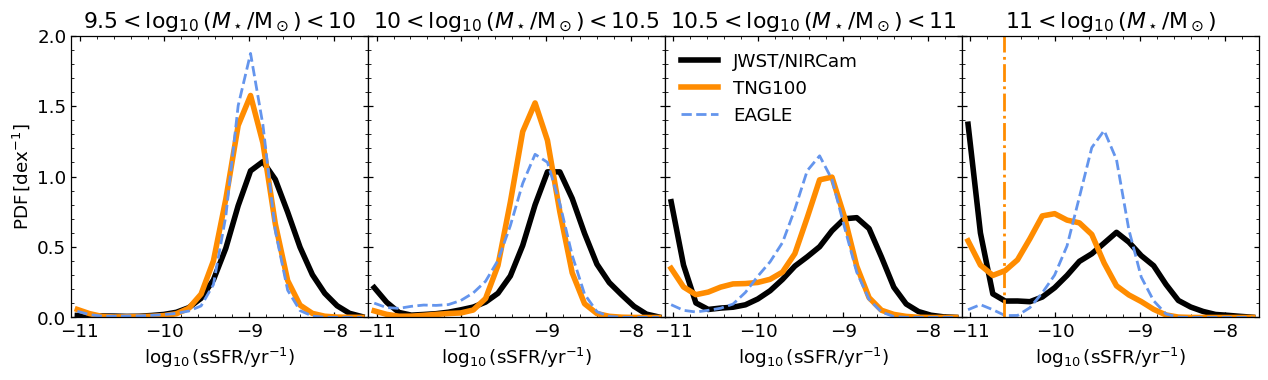

In [15]:
# Figure 10
# Note that SIMBA is missing here (not publicly available)

# Define the stellar mass bins

logmstarBins = np.array([9.5, 10., 10.5, 11., np.inf])
logsSFRBins = np.linspace(-11.1, -7.6, 25)
logsSFRBinMidpoints = (logsSFRBins[1:] + logsSFRBins[:-1]) / 2.
titleList = [r'$9.5<\log_{10}(M_\star/\mathrm{M}_\odot)<10$', r'$10<\log_{10}(M_\star/\mathrm{M}_\odot)<10.5$',
             r'$10.5<\log_{10}(M_\star/\mathrm{M}_\odot)<11$', r'$11<\log_{10}(M_\star/\mathrm{M}_\odot)$']

# Create the plot

datasets = Datasets([JWST_NIRCam, TNG100, EAGLE])

labelList = ['JWST/NIRCam', 'TNG100', 'EAGLE']
colorList = ['black', 'darkorange', 'cornflowerblue']
linewidthList = [4., 4., 2.]
linestyleList = ['-', '-', '--']
sigmaSmoothing = 1.


axes = plt.subplots(figsize=(13., 4.), nrows = 1, ncols = 4)[1]

for idx_panel in range(4):

    # Plot the simulation data

    for idxDataset in range(len(datasets.datasetList)):

        logmstar = datasets.datasetList[idxDataset].getLogmstar()
        sSFR = datasets.datasetList[idxDataset].getsSFR()

        with np.errstate(divide = 'ignore'):
            logsSFR_clipped = np.log10(np.clip(sSFR, a_min = 10**logsSFRBinMidpoints[0], a_max = None)) # Clip galaxies with very low or zero SFR


        SEL_Mstar = (logmstar >= logmstarBins[idx_panel]) * (logmstar < logmstarBins[idx_panel + 1])

        hist = np.histogram(logsSFR_clipped[SEL_Mstar], bins = logsSFRBins, density = True)[0]

        axes[idx_panel].plot(logsSFRBinMidpoints, gauss(hist, sigmaSmoothing, mode = 'nearest'),  linewidth = linewidthList[idxDataset],
            linestyle = linestyleList[idxDataset], color = colorList[idxDataset], label = labelList[idxDataset])

    axes[idx_panel].set_title(titleList[idx_panel])


lg = axes[2].legend(loc = 'upper left')
lg.get_frame().set_linewidth(0.0)
lg.get_frame().set_alpha(0.)

axes[0].set_ylabel(r'$\mathrm{PDF}\,[\mathrm{dex}^{-1}]$')

axes[3].axvline(-10.6, color = 'darkorange', linestyle = '-.', linewidth = 2.)

for ax in axes:

    ax.set_xlabel(r'$\log_{10}(\mathrm{sSFR}/\mathrm{yr}^{-1})$')

    ax.set_xlim(np.min(logsSFRBins), np.max(logsSFRBins))
    ax.set_ylim(0., 2.)

    ax.tick_params(which='both', direction='in', top=True, right=True)
    ax.minorticks_on()

axes[1].set_yticklabels([])
axes[2].set_yticklabels([])
axes[3].set_yticklabels([])

plt.tight_layout()
plt.subplots_adjust(wspace = 0, hspace = 0)
plt.show()
plt.close()

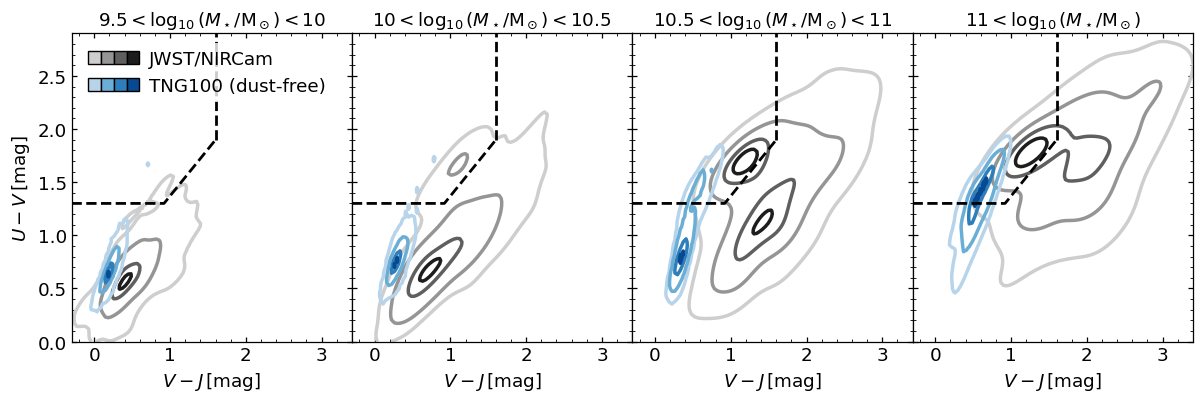

In [16]:
# Figure 11
# Note that SIMBA is missing here (not publicly available)

datasets = Datasets([JWST_NIRCam, TNG100])
datasets.plotUVJdiagram([0, 1], ['Mag_UVJ', 'Mag_UVJ_SKIRT_fDust0_FSPS'], ['Greys', 'Blues'], ['JWST/NIRCam', 'TNG100 (dust-free)'])

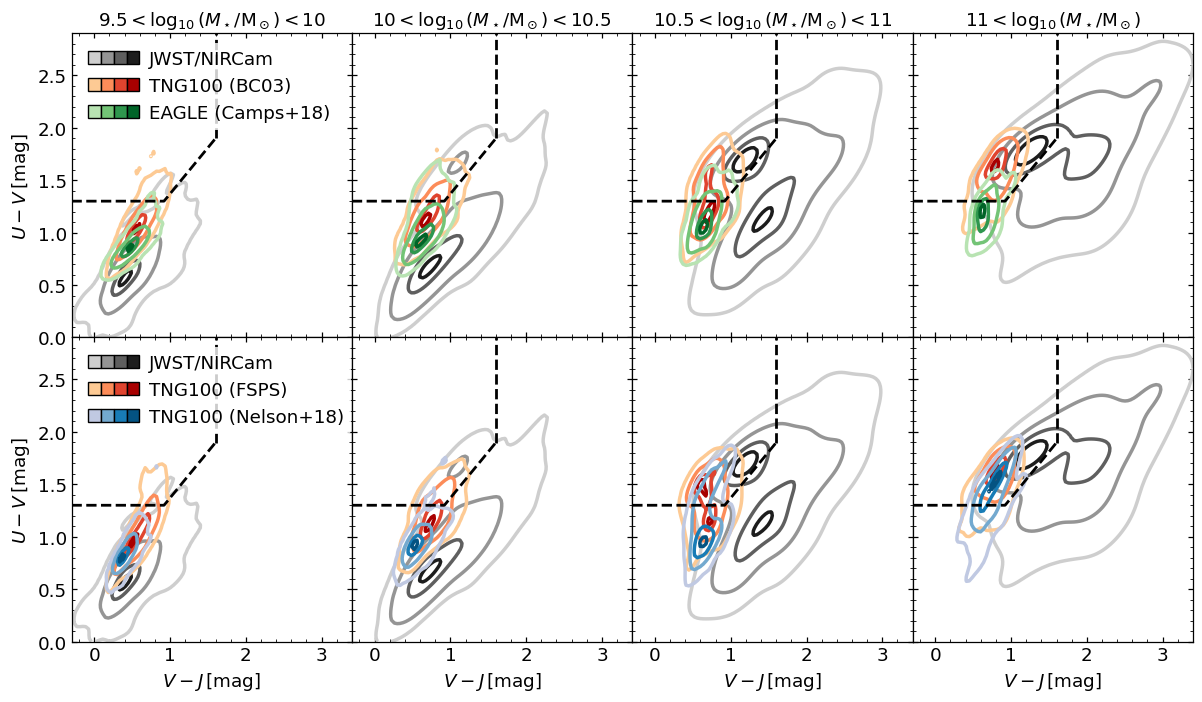

In [17]:
# Figure 12
# Note that SIMBA is missing here (not publicly available)

datasets = Datasets([JWST_NIRCam, TNG100, EAGLE])
datasets.plotUVJdiagram([[0, 1, 2], [0, 1, 1]], [['Mag_UVJ', 'Mag_UVJ_SKIRT_fDust05_BC03_TODDLERS_THEMIS', 'Mag_UVJ'], ['Mag_UVJ', 'Mag_UVJ_SKIRT_fDust05_FSPS_TODDLERS_THEMIS', 'Mag_UVJ_Nelson18']],
    [['Greys', 'OrRd', 'Greens'], ['Greys', 'OrRd', 'PuBu']], [['JWST/NIRCam', 'TNG100 (BC03)', 'EAGLE (Camps+18)'], ['JWST/NIRCam', 'TNG100 (FSPS)', 'TNG100 (Nelson+18)']],
    Nrows = 2)

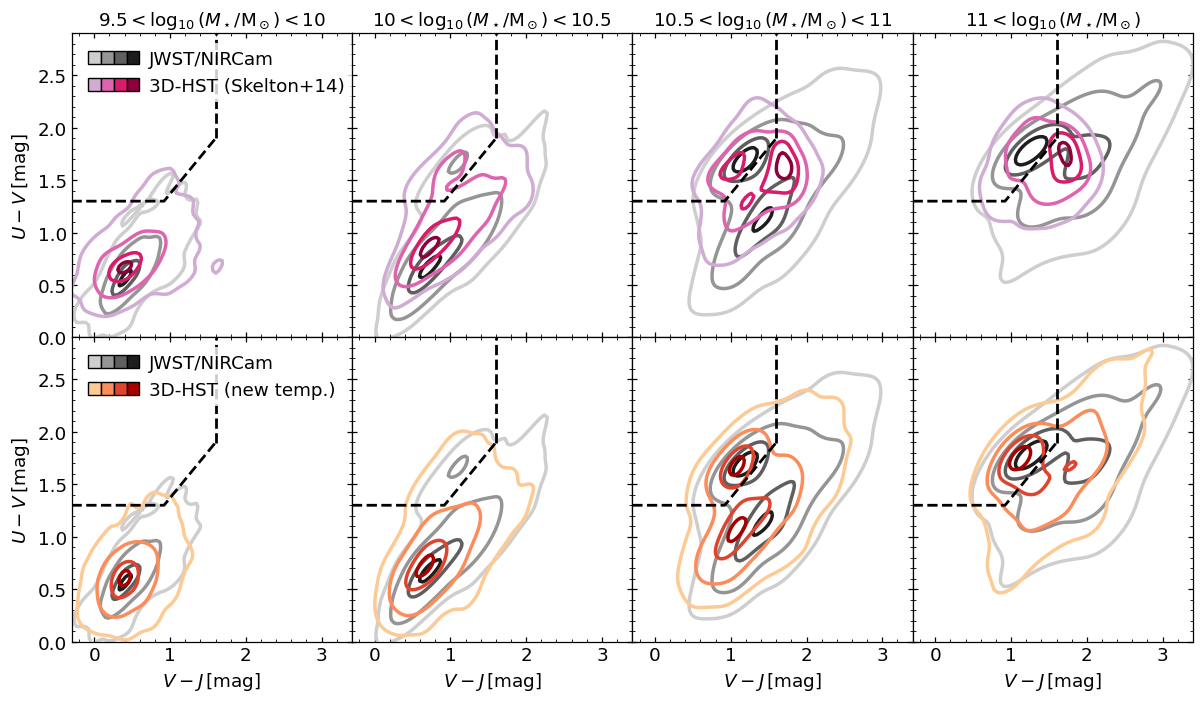

In [18]:
# Figure 13

datasets = Datasets([JWST_NIRCam, HST_Skelton14, HST_Gebek24])
datasets.plotUVJdiagram([[0, 1], [0, 2]], [['Mag_UVJ', 'Mag_UVJ'], ['Mag_UVJ', 'Mag_UVJ']],
    [['Greys', 'PuRd'], ['Greys', 'OrRd']], [['JWST/NIRCam', '3D-HST (Skelton+14)'], ['JWST/NIRCam', '3D-HST (new temp.)']], Nrows = 2)

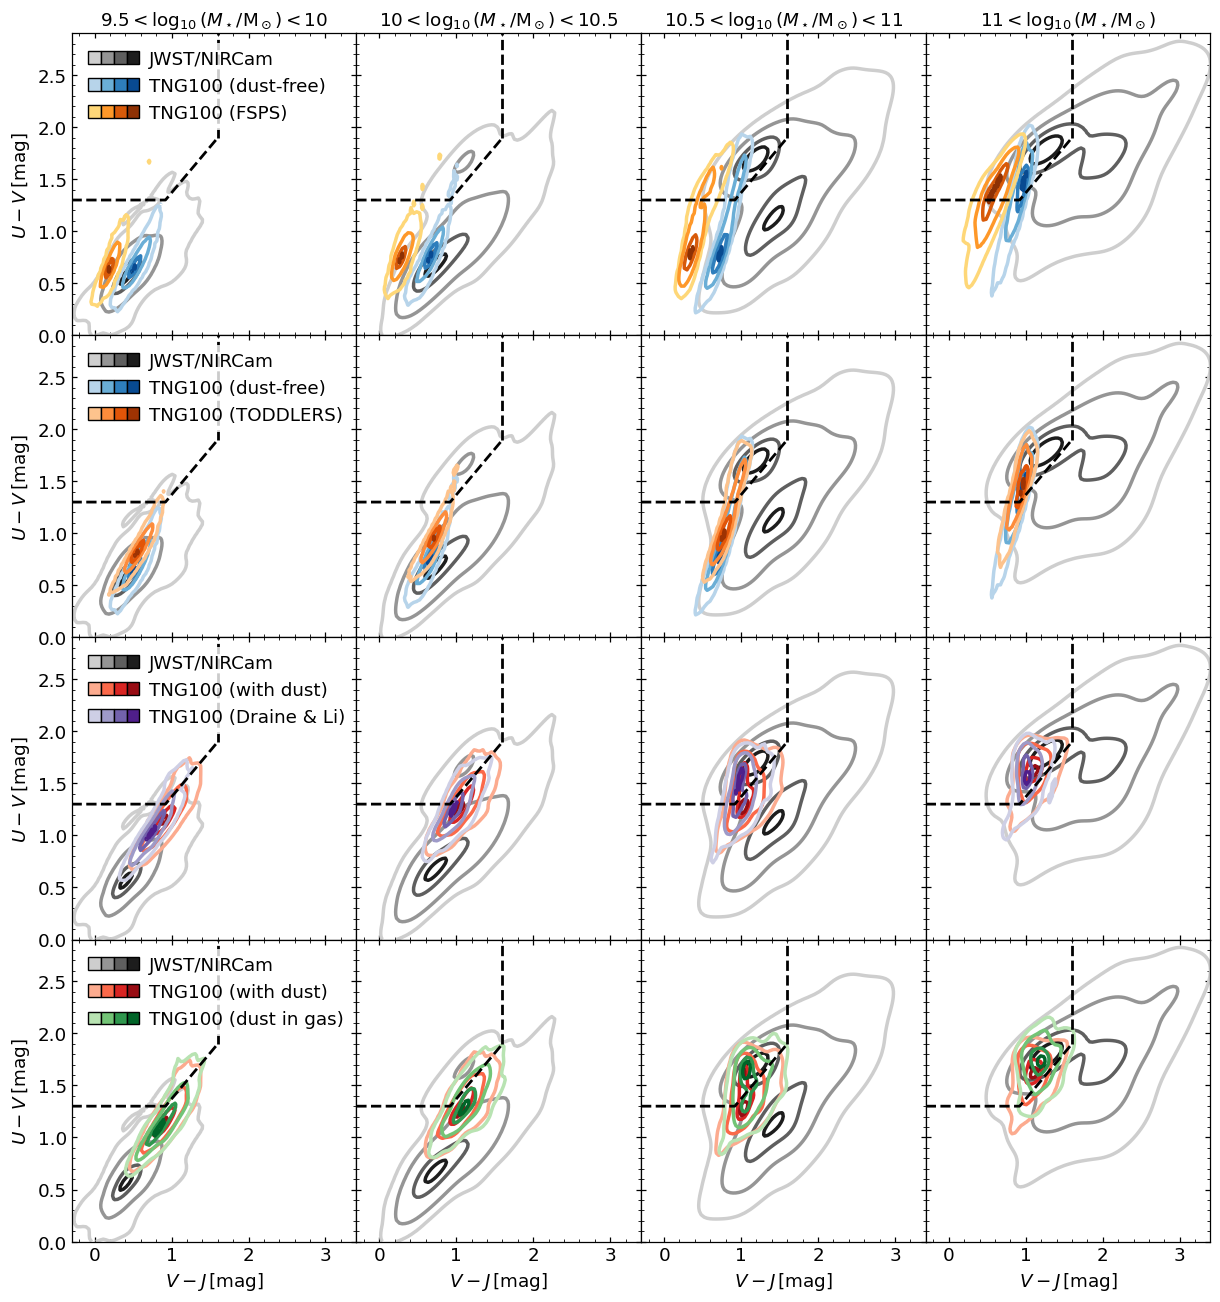

In [19]:
# Figure 14

datasets = Datasets([JWST_NIRCam, TNG100])
datasets.plotUVJdiagram([[0, 1, 1], [0, 1, 1], [0, 1, 1], [0, 1, 1]], [['Mag_UVJ', 'Mag_UVJ_SKIRT_fDust0_BPASS', 'Mag_UVJ_SKIRT_fDust0_FSPS'],
    ['Mag_UVJ', 'Mag_UVJ_SKIRT_fDust0_BPASS', 'Mag_UVJ_SKIRT_fDust0_BPASS_TODDLERS'], ['Mag_UVJ', 'Mag_UVJ_SKIRT_fDust05_BPASS_TODDLERS_THEMIS', 'Mag_UVJ_SKIRT_fDust05_BPASS_TODDLERS_DraineLi'],
    ['Mag_UVJ', 'Mag_UVJ_SKIRT_fDust05_BPASS_TODDLERS_THEMIS', 'Mag_UVJ_SKIRT_fDust05_BPASS_TODDLERS_THEMIS_dustEverywhere']],
    [['Greys', 'Blues', 'YlOrBr'], ['Greys', 'Blues', 'Oranges'], ['Greys', 'Reds', 'Purples'], ['Greys', 'Reds', 'Greens']],
    [['JWST/NIRCam', 'TNG100 (dust-free)', 'TNG100 (FSPS)'], ['JWST/NIRCam', 'TNG100 (dust-free)', 'TNG100 (TODDLERS)'],
    ['JWST/NIRCam', 'TNG100 (with dust)', 'TNG100 (Draine & Li)'], ['JWST/NIRCam', 'TNG100 (with dust)', 'TNG100 (dust in gas)']], Nrows = 4)
